# This notebook 
#### 1. Get the time series from the selected lakes
#### 2. Get data from selected lakes
#####    - Lake shapefile, area
#####    - Lake ice
#### 3. Preprocess ground observation of the selected lakes individually
#### 4. Save dataframe will all the time series preprocessed 
#### 5. Preprocess altis data of the selected lakes 
#### 6. Generate the matching time series of ground and altimeter observations

# Libraries to import 

In [1]:
from ground_data import GroundObservations
from ts_preprocesing import *#get_date_time_cols, convert_units and all the functions 
from ts_plots import *

import geopandas as gpd
import platform
import scipy.interpolate as sc
import geopandas as gpd
import importlib
import pandas as pd
import os
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pytz

from timezonefinder import TimezoneFinder
from pytz import timezone
import timeit
from datetime import datetime
from icecream import ic

utc=pytz.utc
utc.zone
%reload_ext autoreload
%autoreload 2

## Free memory

In [2]:
import gc
gc.collect()

20

# 1. Get the time series from the selected lakes
###  Getting locss stations

In [3]:
# Getting locss stations

go=GroundObservations()
height_fd='height'

lc_lakes=['KHB2','HMT2','PHN2','SAW2','BTN2','QUL2', 'WEW2', 'CFN2','YSL2','SLL2','TAB2','MAB2', 'CQK2', 'SKT2', 'MCW2', 'PAW2', 'MRP2', 'SPA2', 'BLB2','RLH2','MTN2', 'VCN2', 'FDN2']

####NOTE
#VNC2 is the other gauge in Mattamuskeet 
#FDN2 is the other gauge in Phelps


#Read only data from the lakes with the codes specified in lc_lakes
df_locss=go.read_ground_data('LOCSS', station_id=lc_lakes)
df_locss=get_date_time_cols(df_locss, 'date', has_hour=True) #Expand date details in coloumns
stations=df_locss['gauge_id'].unique()

#Unify all the units to the metric system
df_final=convert_units(df_locss,height_fd, origin='FEET', to='METER', unit_fd='unit',
                  gauge_fd='gauge_id')

#Extract gauges that are not operational less than 2 data
lk_id_fd='gauge_id'

df_readings_count=df_final.groupby([lk_id_fd], as_index=False).size()
no_operational_gauges=df_readings_count.loc[df_readings_count['size']<=2][lk_id_fd]


df_final=df_final.loc[~df_final[lk_id_fd].isin(no_operational_gauges)]
print('Initial size',df_final.shape)

#Calculate the differences between consecutive values and dates
#Remove and process duplicate dates

cut_off=0.05 #cut_off for the standard deviation

gauges_list=lc_lakes#df_final[st_id].unique()

date_fd='date'
cols=['gauge_id', 'name', 'date', 'time', 
       'min_height', 'max_height', 'unit', 'source',
       'year', 'month', 'day', 'hour', 'decimal_y']

#use help to see the desciption of filter_extreme_duplicates. i.e., help(filter_extreme_duplicates)         
df_final_nd, df_final_removed, discarded, n_duplicated=filter_extreme_duplicates(df_final, lk_id_fd, date_fd,height_fd, cols, cut_off, gauge_list=gauges_list, exact_date=False)

#Total values outside the cut off. These were filtered out
print("Total values outside cut off: "+str(discarded)+"\n")#df_final_removed[['gauge_id', 'height_count', 'date', 'time', 'height_std']])
print("Total duplicated values: "+str(n_duplicated))
# print("Gauges with values in the same date: \n", df_final_nd.gauge_id.unique())

# df_final_nd.gauge_id.unique()
# gauges_list
df_final_nd.rename(columns={'height_rc':height_fd}, inplace=True)
# df_final_nd
# #Extract the ones with duplicates from df_final
df_temp=df_final.loc[~df_final[lk_id_fd].isin(df_final_nd[lk_id_fd].unique())]
df_temp
df_temp=pd.concat((df_temp, df_final_nd), axis=0)
print('Final size',df_temp.shape)
#Total save data for suplememntal material 

df_temp.loc[~(df_temp['height_count'].isnull())&(df_temp['height_count']>=2)].to_csv('../data/for_paper/sumary_LOCSS_same_date.csv')
df_final_removed.to_csv('../data/for_paper/LOCSS_removed_cut_off.csv')

Initial size (4006, 18)
Total values outside cut off: 1

Total duplicated values: 35
Final size (3969, 20)


# 1. Get the time series from the selected lakes
### Getting ARHN stations from file
### Getting USGS stations from file. Still working on R script connection to get them from USGS
### Getting Brazilian Reservoirs from file

In [4]:
# Getting ARHN stations 

# #'2102' Is a meteorlogical station 
ar_lakes=['1824', '2830', '1830','2832', '2028','2231','2234','2300','2316']#'1805', '1819',
skip_rows=1

df_arhn=go.read_ground_data('ARHN', skip_rows=skip_rows, station_id=ar_lakes)
df_arhn=get_date_time_cols(df_arhn, 'date', has_hour=True)

# Getting USGS stations from file. Still working on R script connection
us_lakes=['2464800','6903880','6604000']
df_usgs=go.read_ground_data('USGS',station_id=us_lakes)
df_usgs=get_date_time_cols(df_usgs, 'date')
df_usgs=convert_units(df_usgs,height_fd, origin='FEET', to='METER', 
                  gauge_fd='gauge_id')

# Getting Brazilian Reservoirs
rvbr_lakes=['19069','19060','19126', '12030', '12036', '12327','12056']
df_rvbr=go.read_ground_data('RVBR', station_id=rvbr_lakes)
df_rvbr=get_date_time_cols(df_rvbr,'date')

#### Concat all the ground observations in a single dataframe

In [5]:
#Relevant columns
# df_ground_ts=pd.DataFrame()
common_cols=['gauge_id','source','decimal_y','height','date','year', 'month', 'day', 'hour']
# df_usgs[common_cols]
df_ground_ts=pd.concat((df_usgs[common_cols].copy(),df_arhn[common_cols].copy(), df_temp[common_cols].copy(), df_rvbr[common_cols].copy()), axis=0)

# df_ground_ts=df_temp[common_cols].copy()
df_ground_ts['doy']=df_ground_ts['date'].dt.dayofyear
df_ground_ts.shape
# pd.datetime(+pd.to_datetime(df_final['time'], format='%H:%M:%S'), format='%Y-%m-%d %H:%M:%S')
# df_ground_ts.columns

(362785, 10)

# 2. Get data from selected lakes
###   - Lake shapefile, area, lake name
###   - Lake ice
###  Generate the file with all the initial preprocesing 

In [6]:
#Get all lakes 
if platform.system()=='Linux':
    path_lakes='/home/angelica/Dropbox/Research/LOCSS/other_lakes/Selected_lakes/all_lakes_paper.shp'#wgs84_f.shp'
else:
    path_lakes='C:/Users/amgomez/Dropbox/Research/LOCSS/other_lakes/Selected_lakes/all_lakes_paper.shp'#wgs84_f.shp'

df_sel_lakes=gpd.read_file(path_lakes)

#Read all the gauges with time series to process. This file contain the lake ids that will be used in the computated. It is used to filter the shapefile dataframe
path= '../data/alti_timeseries/lonlat_vs_altis_ed.csv'


if platform.system()=='Linux':
    altis_csv=pd.read_csv(path, sep=',',encoding='iso-8859-1')
else:
    altis_csv=pd.read_csv(path, sep=',', encoding='windows-1252')  

selected_lakes=altis_csv['lake_id'].dropna().unique()
selected_lakes=[str(int(x)) for x in selected_lakes]
#merge name based on gauge_id
df_lake_name=df_sel_lakes.loc[df_sel_lakes['lake_id'].isin(selected_lakes), ['gauge_id','lake_name', 'lake_id']]

# Manually add gauge ids of lakes that have more than one gauge and did not have gauge id
temp_2gauge=df_lake_name.loc[(df_lake_name['gauge_id']=='PHN2')|(df_lake_name['gauge_id']=='MTN2')].copy()
temp_2gauge['gauge_id']=None
df_lake_name=pd.concat([df_lake_name,temp_2gauge])

for index,x in df_lake_name.loc[df_lake_name['gauge_id'].isna()].iterrows():
    lkid=x['lake_id']
    gauge_id=altis_csv.loc[altis_csv['lake_id']==int(lkid), 'station_id'].values[0]
    df_lake_name.loc[df_lake_name['lake_id']==lkid, 'gauge_id']=gauge_id

df_ground_ts=pd.merge(df_ground_ts, df_lake_name, on='gauge_id',how='left')

In [331]:
#Section discarted 
#Add the ice covered from Xiao's code

# df_ice=pd.read_csv('../data/locss_ice.csv')
# df_ice
# df_ice=pd.merge(df_ice, df_sel_lakes[['Hylak_id', 'gauge_id']], on='Hylak_id', how='left')
# df_ground_ts=pd.merge(df_ground_ts, df_ice[['Hylak_id', 'gauge_id','SLIDE_snowIce','doy']], on=['gauge_id','doy'], how='left')
# df_ground_ts.to_csv('../data/temp_sample_LOCSS_data.csv')


# 3. Preprocess ground observation of the selected lakes individually

In [7]:
# first, create a copy just in case
df_ground_ts_org=df_ground_ts.copy()

In [15]:
# df_ground_ts=df_ground_ts_org.copy()


In [28]:
#Function to plot before and after
import matplotlib.ticker as ticker
def plot_ts_preproc(df_before, df_after, st_id, date_fd, height_fd, labels):
    title=labels['title']['label']
    title_s=labels['title']['size']
    x_label=labels['x']['label']
    y_label=labels['y']['label']
    xl_font_size=labels['x']['font_lbl_s']
    x_interval=labels['x']['freq_interval']
    yl_font_size=labels['y']['font_lbl_s']
    xl_tick_size=labels['x']['tick_s']
    yl_tick_size=labels['y']['tick_s']
    
    df1=df_before
    df1=df1.sort_values(by=date_fd)
    fig1, ax= plt.subplots(figsize=(20, 6))
    plt.plot(df1[date_fd], df1[height_fd], linewidth=5)
    plt.title(st_id+' before'+title, fontsize=title_s)

    ax.set_xlabel(x_label, fontsize=xl_font_size)
    ax.set_ylabel(y_label,fontsize=yl_font_size)
    ax.set_yticklabels(ax.get_yticks(),size = yl_tick_size)
    
    # Make ticks on occurrences of each month:
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    # Get only the month to show in the x-axis:
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=x_interval))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.set_xlim(df1[date_fd].min(), df1[date_fd].max())
    plt.xticks(fontsize=xl_tick_size)
    plt.gcf().autofmt_xdate()
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
    plt.subplots_adjust(bottom=0.15)
    
    for pos in ['top', 'right']:
        plt.gca().spines[pos].set_visible(False)
    
    
    df1=df_after
    df1=df1.sort_values(by=date_fd)
    fig2, ax=plt.subplots(figsize=(20, 6))
    plt.plot(df1[date_fd], df1[height_fd], linewidth=5)
    plt.title(st_id+' after'+ title, fontsize=title_s)
    ax.set_xlabel(x_label, fontsize=xl_font_size)
    ax.set_ylabel(y_label,fontsize=yl_font_size)
    ax.set_yticklabels(ax.get_yticks(),size = yl_tick_size)
    
    # Make ticks on occurrences of each month:
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    # Get only the month to show in the x-axis:
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=x_interval))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.set_xlim(df1[date_fd].min(), df1[date_fd].max())
    plt.xticks(fontsize=xl_tick_size)
    plt.gcf().autofmt_xdate()
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
    plt.subplots_adjust(bottom=0.15)
    for pos in ['top', 'right']:
        plt.gca().spines[pos].set_visible(False)
    return fig1, fig2
    

### Extract and move reference point of the stations KHB2
#### Reason: The gauge is moved during the monitoring, the reference point moves as well


/tmp/ipykernel_1695888/2652770570.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),size = yl_tick_size)
/tmp/ipykernel_1695888/2652770570.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),size = yl_tick_size)


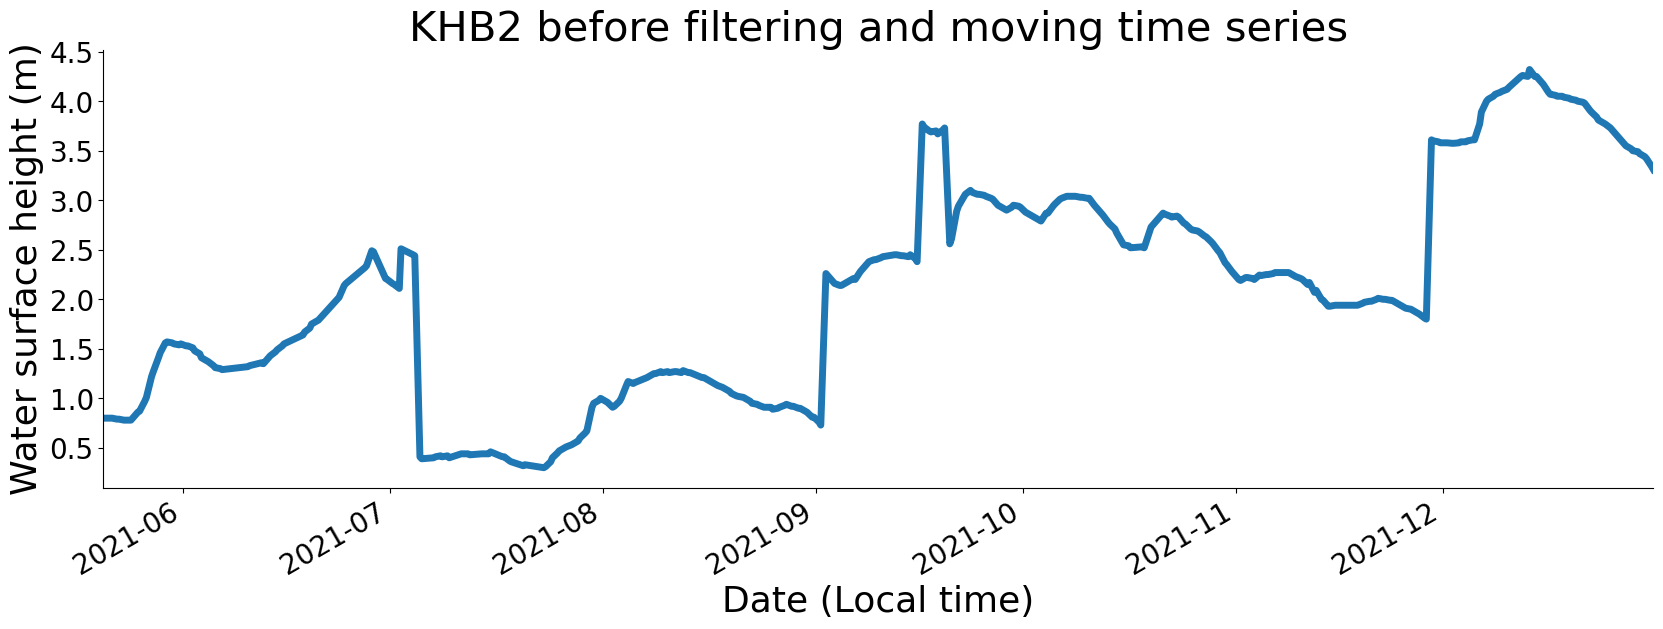

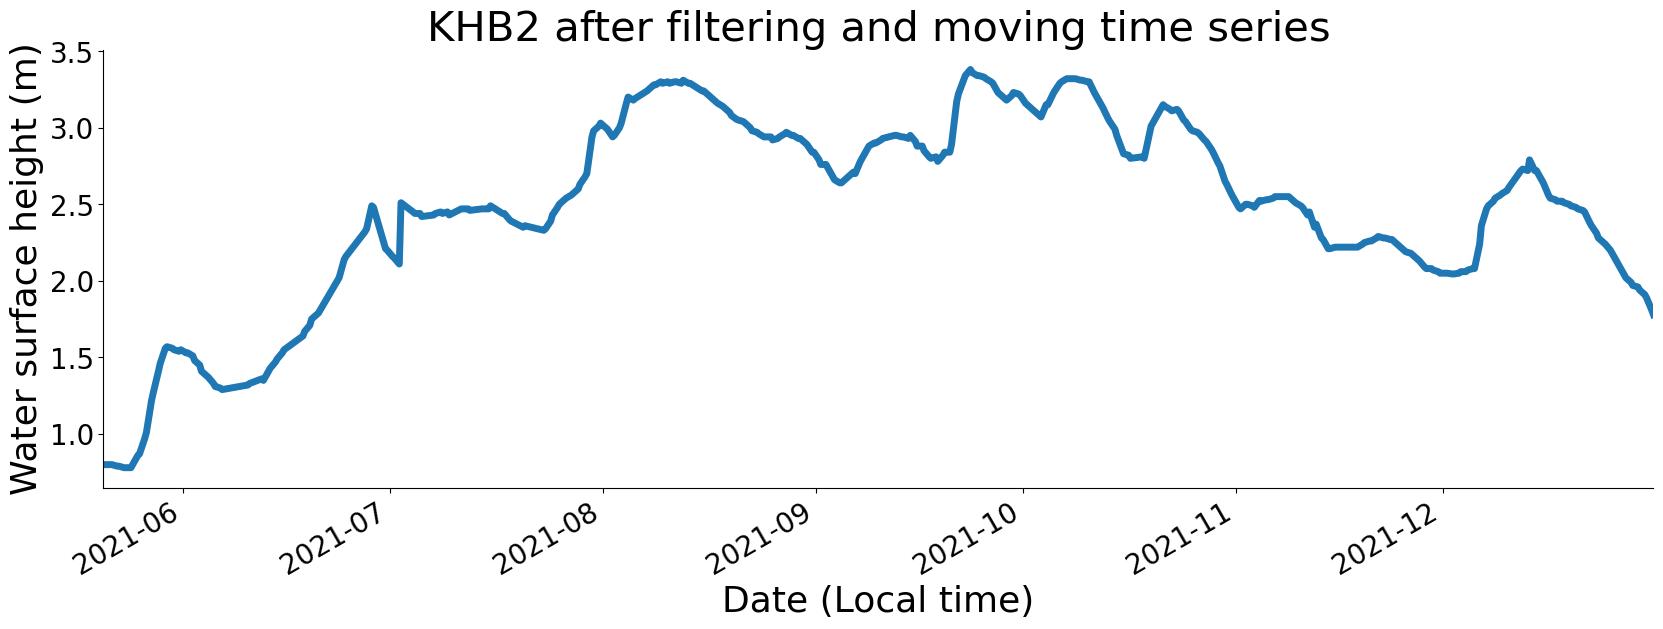

In [9]:
import matplotlib.dates as mdates

df=df_ground_ts.copy()
st_id_fd='gauge_id'
st_id='KHB2'
date_fd='decimal_y'
height_fd='height'
low_lim=-.5
high_lim=.5

df_ground_ex, df_ground_re,df_diff_to_remove=extract_data_gauge(df, st_id_fd, st_id, date_fd, height_fd, low_lim, high_lim)
df_diff_to_remove
date_fd='date'
diff_fd='diff'



if df_diff_to_remove.empty:
    df1=df_ground_ts.loc[df_ground_ts[st_id_fd]==st_id]
    fig, ax=plt.subplots(figsize=(20, 6))
    ax.plot(df1[date_fd], df1[height_fd])
    plt.title(st_id+' Already ok', fontsize=20)
    # ax=plt.gcf()
    # label = ax.yaxis.get_major_ticks()[2].label
    ax.set_xlabel('Date (Local time)', fontsize=18)
    ax.set_ylabel('Water surface height (m)',fontsize=18)
    ax.set_yticklabels(ax.get_yticks(),size = 16)
    # ax.set_xticklabels(ax.get_xticks(),size = 16)
    # ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')
    # Make ticks on occurrences of each month:
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    # Get only the month to show in the x-axis:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(fontsize=16)
    ax.set_xlim(df1[date_fd].min(), df1[date_fd].max())
    for pos in ['top', 'right']:
        plt.gca().spines[pos].set_visible(False)
    
else:
    df_ground_fixed=remove_extreme_data(df_ground_ex,df_diff_to_remove, date_fd, height_fd, diff_fd)
    df_ground_ts=pd.concat((df_ground_re,df_ground_fixed), axis=0)

    #plot goes in here
    title=' filtering and moving time series'
    labels={'title':{'label':title, 'size':30},
       'x':{'label':'Date (Local time)', 'font_lbl_s':26, 'tick_s':20,'freq_interval':1},
       'y':{'label':'Water surface height (m)', 'font_lbl_s':26,'tick_s':20 }
       }

    # labels=dict({'title': title, 'y': 'Water Surface Height (m)'})

    fig1, fig2=plot_ts_preproc(df_ground_ex,df_ground_ts.loc[df_ground_ts[st_id_fd]==st_id], st_id, date_fd, height_fd, labels)

# ax=plt.gfc()

### Save figures for supplemental material in the paper

In [336]:
fig1.savefig('../data/for_paper/Fig_S1_a.png', transparent=True, dpi=300)
fig2.savefig('../data/for_paper/Fig_S1_b.png', transparent=True, dpi=300)

### Extract and move reference point of the stations TAB2
#### Reason: The gauge is moved during the monitoring, the reference point moves as well

/tmp/ipykernel_1695888/2652770570.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),size = yl_tick_size)
/tmp/ipykernel_1695888/2652770570.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),size = yl_tick_size)


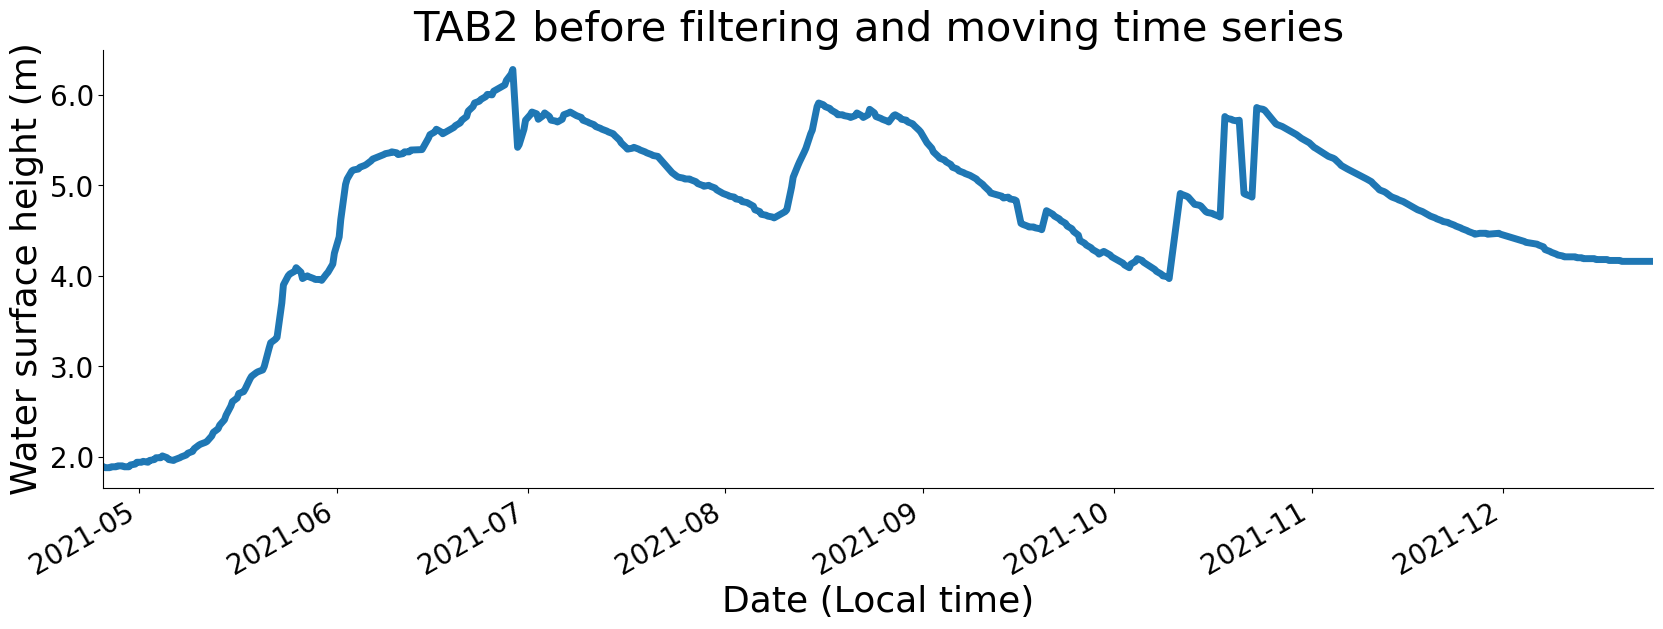

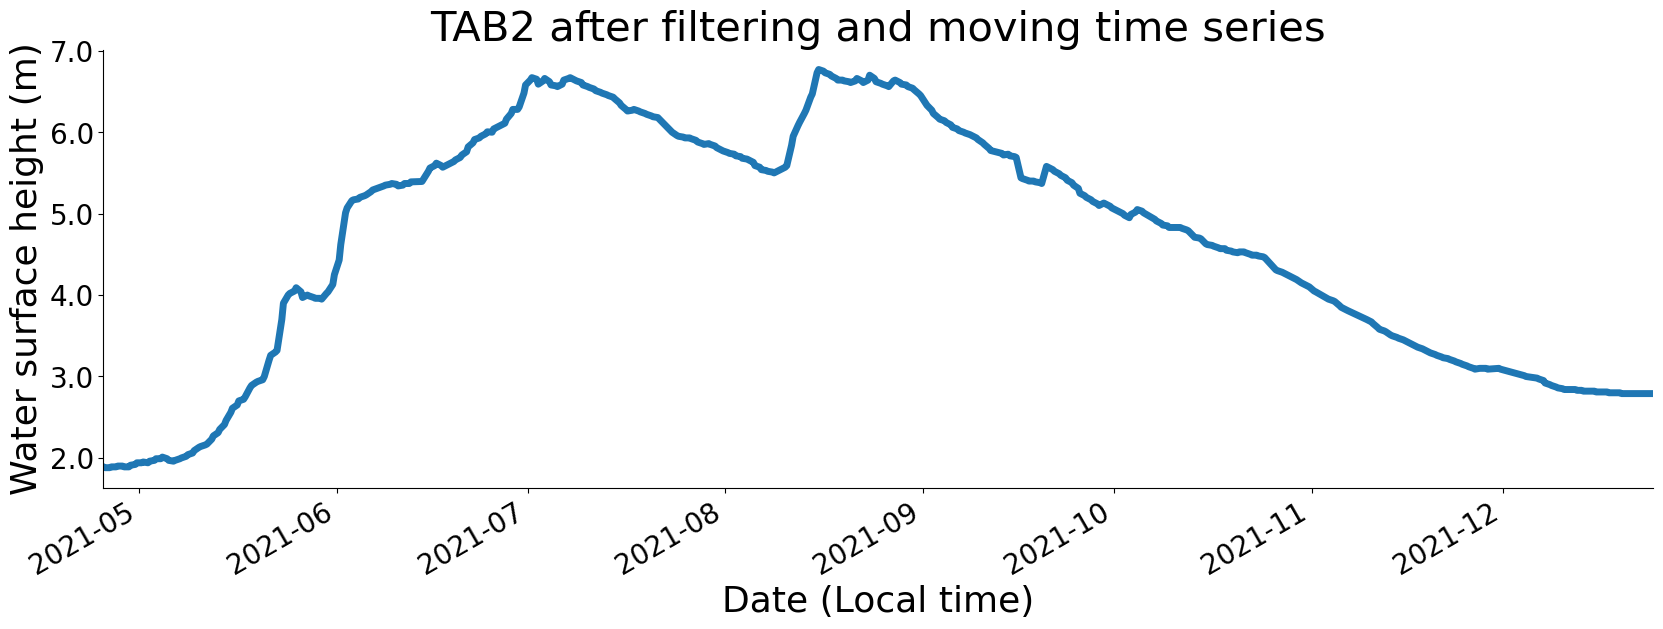

In [10]:
df=df_ground_ts.copy()
st_id_fd='gauge_id'
st_id='TAB2'
date_fd='decimal_y'
height_fd='height'
low_lim=-.5
high_lim=.5

df_ground_ex, df_ground_re,df_diff_to_remove=extract_data_gauge(df, st_id_fd, st_id, date_fd, height_fd, low_lim, high_lim)
df_diff_to_remove
date_fd='date'
diff_fd='diff'



if df_diff_to_remove.empty:
    df1=df_ground_ts.loc[df_ground_ts[st_id_fd]==st_id]
    fig, ax=plt.subplots(figsize=(20, 6))
    ax.plot(df1[date_fd], df1[height_fd])
    plt.title(st_id+' Already ok', fontsize=20)
    # ax=plt.gcf()
    # label = ax.yaxis.get_major_ticks()[2].label
    ax.set_xlabel('Date (Local time)', fontsize=18)
    ax.set_ylabel('Water surface height (m)',fontsize=18)
    ax.set_yticklabels(ax.get_yticks(),size = 16)
    # ax.set_xticklabels(ax.get_xticks(),size = 16)
    # ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')
    # Make ticks on occurrences of each month:
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    # Get only the month to show in the x-axis:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(fontsize=16)
    ax.set_xlim(df1[date_fd].min(), df1[date_fd].max())
    for pos in ['top', 'right']:
        plt.gca().spines[pos].set_visible(False)
    
else:
    df_ground_fixed=remove_extreme_data(df_ground_ex,df_diff_to_remove, date_fd, height_fd, diff_fd)
    df_ground_ts=pd.concat((df_ground_re,df_ground_fixed), axis=0)

    #plot goes in here
    title=' filtering and moving time series'
    labels={'title':{'label':title, 'size':30},
       'x':{'label':'Date (Local time)', 'font_lbl_s':26, 'tick_s':20,'freq_interval':1},
       'y':{'label':'Water surface height (m)', 'font_lbl_s':26,'tick_s':20 }
       }

    # labels=dict({'title': title, 'y': 'Water Surface Height (m)'})

    fig1, fig2=plot_ts_preproc(df_ground_ex,df_ground_ts.loc[df_ground_ts[st_id_fd]==st_id], st_id, date_fd, height_fd, labels)


### Save figures for supplemental material in the paper

In [338]:
fig1.savefig('../data/for_paper/Fig_S1_c.png', transparent=True, dpi=300)
fig2.savefig('../data/for_paper/Fig_S1_d.png', transparent=True, dpi=300)

### Extract anomalous values stations MTN2 (Lake Mattamuskeet West)
#### Reason: There is a extreme value TO-DO: Pending to describe this better

/tmp/ipykernel_1695888/2652770570.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),size = yl_tick_size)
/tmp/ipykernel_1695888/2652770570.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),size = yl_tick_size)


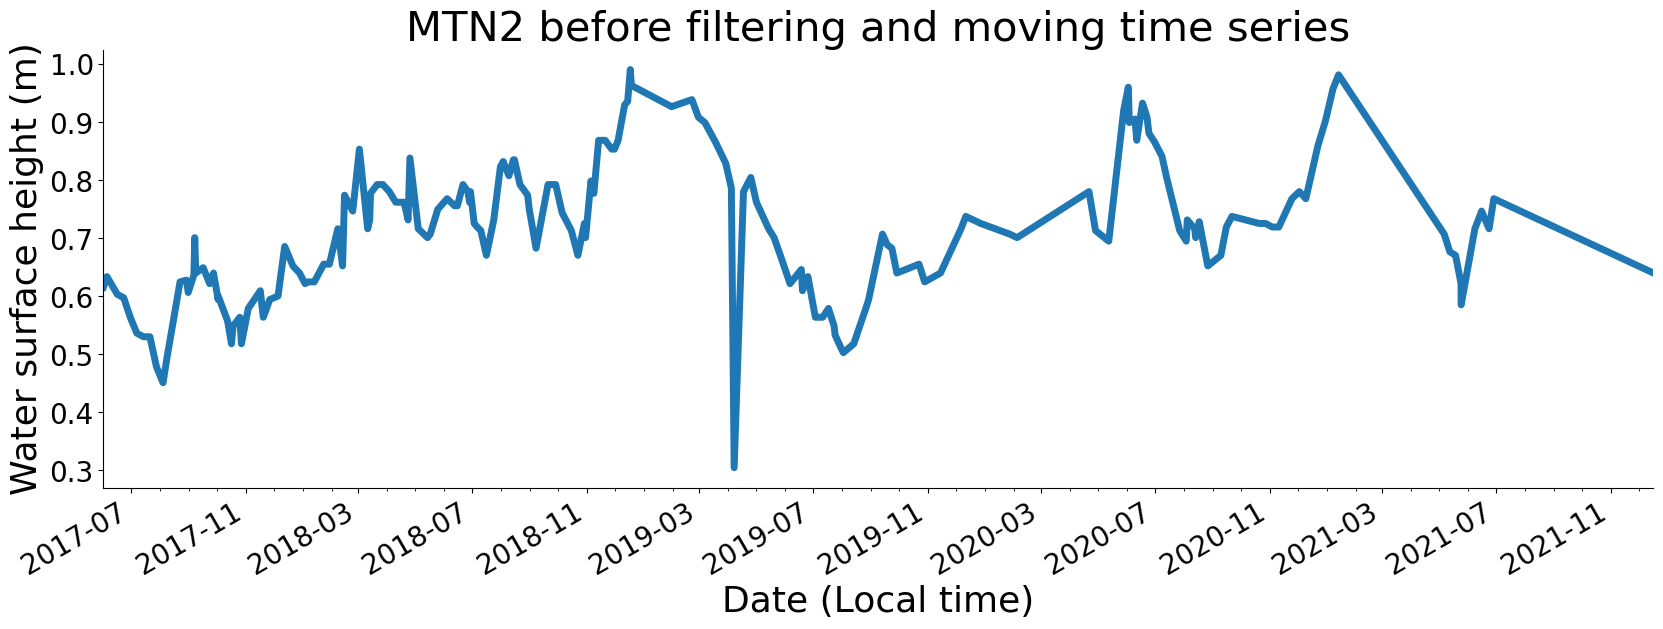

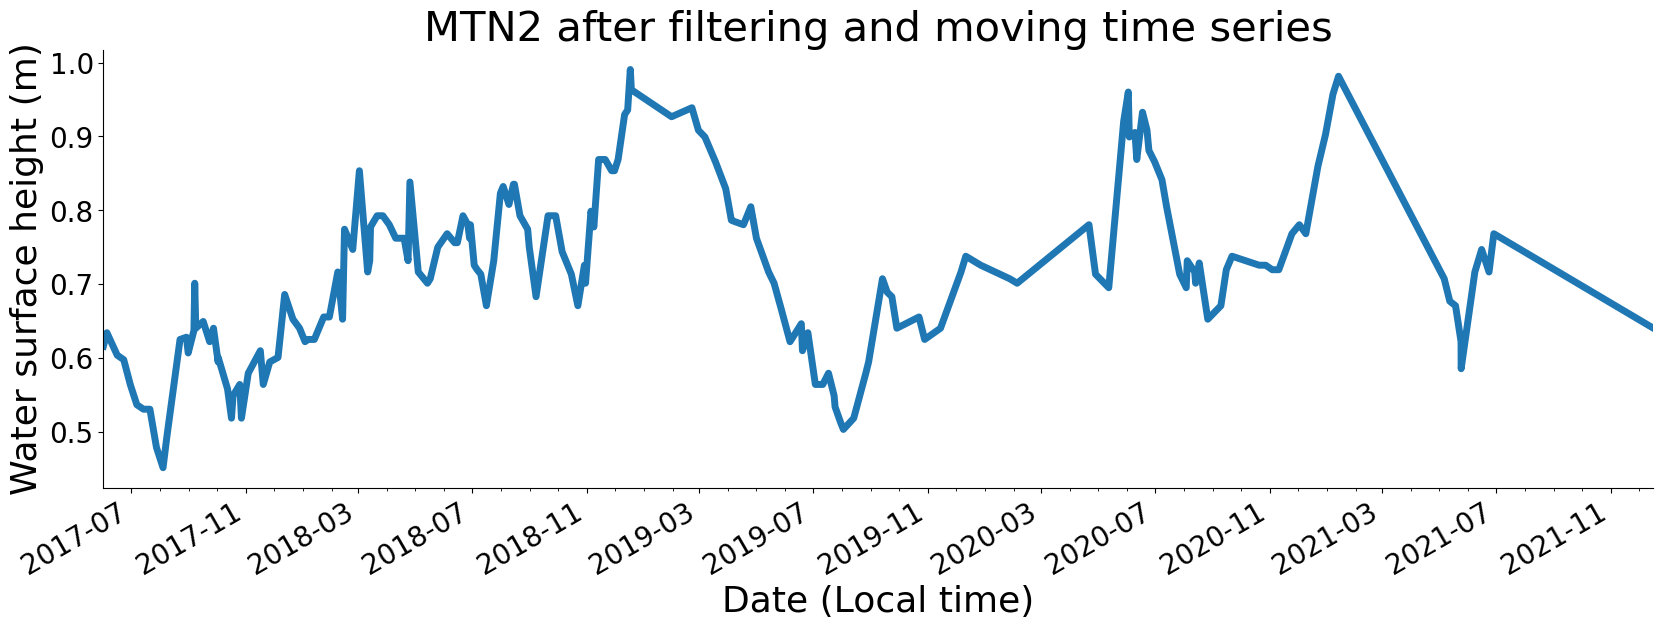

In [11]:
import matplotlib.ticker as ticker
df=df_ground_ts.copy()
st_id_fd='gauge_id'
st_id='MTN2'
date_fd='decimal_y'
height_fd='height'
low_lim=-.4
high_lim=.4

df_ground_ex, df_ground_re,df_diff_to_remove=extract_data_gauge(df, st_id_fd, st_id, date_fd, height_fd, low_lim, high_lim)
df_diff_to_remove
date_fd='date'
diff_fd='diff'



if df_diff_to_remove.empty:
    df1=df_ground_ts.loc[df_ground_ts[st_id_fd]==st_id]
    fig, ax=plt.subplots(figsize=(20, 6))
    ax.plot(df1[date_fd], df1[height_fd])
    plt.title(st_id+' Already ok', fontsize=20)
    # ax=plt.gcf()
    # label = ax.yaxis.get_major_ticks()[2].label
    ax.set_xlabel('Date (Local time)', fontsize=18)
    ax.set_ylabel('Water surface height (m)',fontsize=18)
    
    # ax.set_xticklabels(ax.get_xticks(),size = 16)
    
    ax.set_yticklabels(ax.get_yticks(),size = 16)
    # Make ticks on occurrences of each month:
    ax.xaxis.set_major_locator(ticker.FixedLocator(mdates.MonthLocator()))
    ax.xaxis.set_minor_locator(ticker.FixedLocator(mdates.MonthLocator()))
    # Get only the month to show in the x-axis:
    ax.xaxis.set_major_locator(ticker.FixedLocator(mdates.MonthLocator(interval=4)))
    ax.xaxis.set_major_formatter(ticker.FixedLocator(mdates.DateFormatter('%Y-%m')))
    
    plt.xticks(fontsize=16)
    ax.set_xlim(df1[date_fd].min(), df1[date_fd].max())
    plt.gcf().autofmt_xdate()
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
    for pos in ['top', 'right']:
        plt.gca().spines[pos].set_visible(False)
    
else:
    df_ground_fixed=remove_extreme_data(df_ground_ex,df_diff_to_remove, date_fd, height_fd, diff_fd)
    df_ground_ts=pd.concat((df_ground_re,df_ground_fixed), axis=0)

    #plot goes in here
    title=' filtering and moving time series'
    labels={'title':{'label':title, 'size':30},
       'x':{'label':'Date (Local time)', 'font_lbl_s':26, 'tick_s':20, 'freq_interval':4},
       'y':{'label':'Water surface height (m)', 'font_lbl_s':26,'tick_s':20 }
       }

    # labels=dict({'title': title, 'y': 'Water Surface Height (m)'})

    fig1, fig2=plot_ts_preproc(df_ground_ex,df_ground_ts.loc[df_ground_ts[st_id_fd]==st_id], st_id, date_fd, height_fd, labels)


### Save figures for supplemental material in the paper

In [340]:
fig1.savefig('../data/for_paper/Fig_time_series correction.png', transparent=True, dpi=300)
fig2.savefig('../data/for_paper/Fig_time_series correction.png', transparent=True, dpi=300)

### Plot values from the two stations at Lake Mattamuskeet and Lake Phelps
#### For each lake
#### 1. Find values at the same date
#### 2. Plot the trend line
#### 3. Save the plot

In [12]:
def get_same_dates(df, gauge_id_fd, height_fd, date_fd, st_id_list, how='inner'):
    st_id_g1=st_id_list[0]
    st_id_g2=st_id_list[1]    

    df_G1=df[[gauge_id_fd,date_fd,height_fd]].loc[df[gauge_id_fd]==st_id_g1].copy()

    df_G2=df[[gauge_id_fd,date_fd,height_fd]].loc[df[gauge_id_fd]==st_id_g2].copy()

    df_common_dates=df_G1.merge(df_G2, on=date_fd, how=how).drop_duplicates()

    df_common_dates.rename(columns={'height_x':'height '+st_id_g1,'height_y':'height '+st_id_g2}, inplace=True)
    
    return df_common_dates
    

    
def plot_comparing_gauges(df,x,y, lb_x, lbx, normalized=False):
    
    if normalized:
        df[x+'_norm']=df[x]-df[x].mean()
        df[y+'_norm']=df[y]-df[y].mean()
        x=x+'_norm'
        y=y+'_norm'

    fig=px.scatter(df, x=x,y=y, trendline='ols', template='simple_white', color_discrete_sequence=['#1b9e77'], trendline_color_override="#7570b3")



    fig.for_each_yaxis(lambda y: y.update(title = ''))
    fig.for_each_xaxis(lambda y: y.update(title = ''))
    fig.add_annotation(x=-0.1,y=0.5,
                       text='<b>'+lb_y+'</b>', textangle=-90,
                       showarrow=False,
                       font=dict(size=18),
                       xref="paper", yref="paper")
    fig.add_annotation(x=0.5,y=-0.1,
                       text='<b>'+lb_x+'</b>', 
                       showarrow=False,
                       font=dict(size=18),
                       xref="paper", yref="paper")
    fig.add_annotation(x=0.5,y=-0.1,
                       text='<b>'+lb_x+'</b>', 
                       showarrow=False,
                       font=dict(size=18),
                       xref="paper", yref="paper")
    fig.update_xaxes(matches=None, showline=True, linewidth=2)
    fig.update_yaxes(matches=None, showline=True, linewidth=2)

    fig.update_layout(height=800, width=900,
                     yaxis = dict(tickfont = dict(size=18)),
                     xaxis = dict(tickfont = dict(size=18)))
    fig.show()
    results = px.get_trendline_results(fig)

    results.px_fit_results.iloc[0].summary()
    return fig

In [18]:
df=df_ground_ts.copy()

st_id_fd='gauge_id'
date_fd='decimal_y'
height_fd='height'

st_id_list=['VCN2','MTN2']
df_common_dates_VCMT=get_same_dates(df,st_id_fd,height_fd,date_fd, st_id_list)
# The scope of these changes made to
# pandas settings are local to with statement.
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 8,
                       ):
    print('Heights on the same date Lake Mattamuskeet\n',df_common_dates_VCMT)
    
st_id_list=['FDN2','PHN2']

df_common_dates_FDPH=get_same_dates(df,st_id_fd,height_fd,date_fd, st_id_list )
# The scope of these changes made to
# pandas settings are local to with statement.
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 8,
                       ):
    print('\nHeights on the same date Lake Phelps\n',df_common_dates_FDPH)

Heights on the same date Lake Mattamuskeet
   gauge_id_x      decimal_y  height VCN2 gauge_id_y  height MTN2
0       VCN2  2019.42852169     0.646176       MTN2     0.621792

Heights on the same date Lake Phelps
 Empty DataFrame
Columns: [gauge_id_x, decimal_y, height FDN2, gauge_id_y, height PHN2]
Index: []


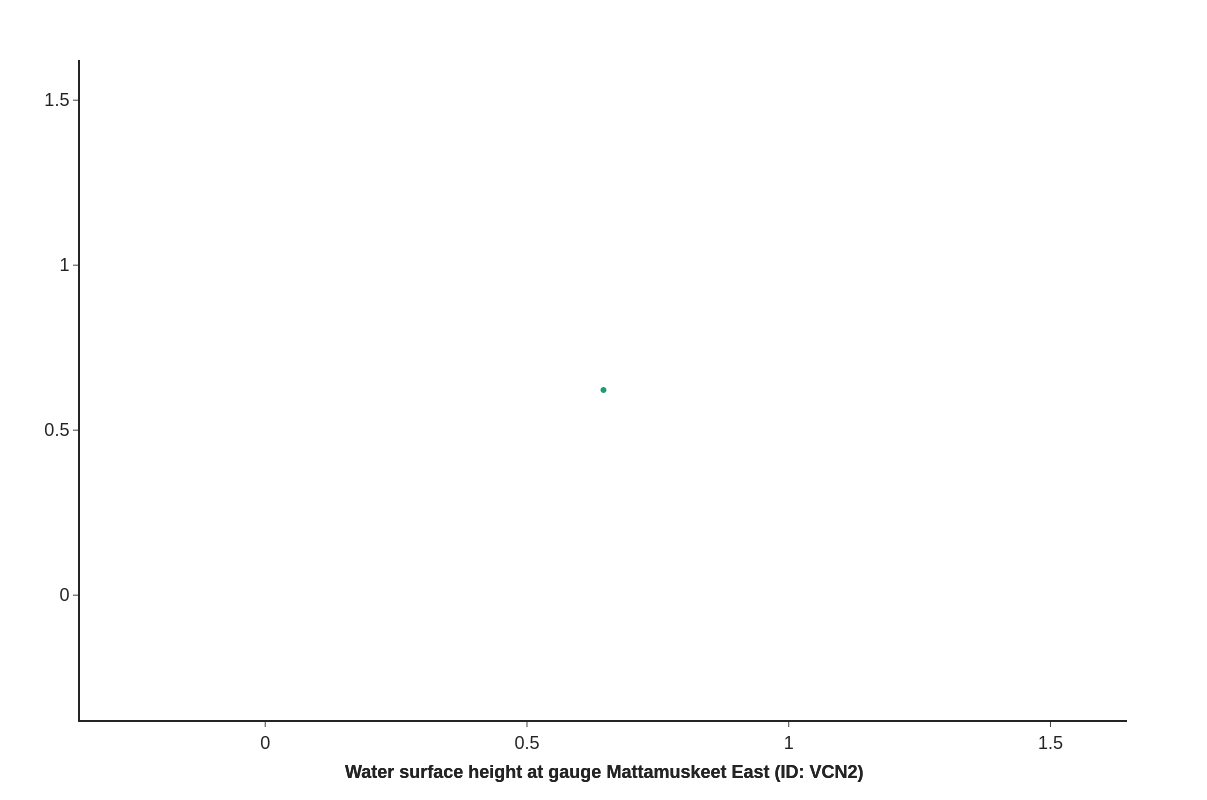

AttributeError: 'DataFrame' object has no attribute 'px_fit_results'

In [23]:
import plotly.express as px
# plt.style.use('default')
# plt.rcParams["figure.figsize"] = (15,5)
lb_x='Water surface height at gauge Mattamuskeet East (ID: VCN2)'
lb_y='Water surface height at gauge Mattamuskeet West (ID: MTN2)'

df=df_common_dates_VCMT.copy()
x='height VCN2'
y='height MTN2'
figMM=plot_comparing_gauges(df,x,y, lb_x, lb_y)

lb_x='Normalized water surface height gauge VCN2'
lb_y='Normalized water surface height gauge MTN2'
figMM_N=plot_comparing_gauges(df,x,y, lb_x, lb_y, normalized=True)

lb_x='Water surface height at gauge Phelps (ID: FDN2)'
lb_y='Water surface height at gauge Phelps East (ID: PHN2)'

df=df_common_dates_FDPH.copy()
x='height FDN2'
y='height PHN2'

figPP=plot_comparing_gauges(df,x,y, lb_x, lb_y)


lb_x='Normalized water surface height gauge FDN2'
lb_y='Normalized water surface height gauge PHN2'
figPP_N=plot_comparing_gauges(df,x,y, lb_x, lb_y, normalized=True)

In [485]:
figMM.write_image('../data/for_paper/Fig_same_lake_two_gauges_Mattamuskeet.pdf')
figMM_N.write_image('../data/for_paper/Fig_same_lake_two_gauges_Mattamuskeet_norm.pdf')
figPP.write_image('../data/for_paper/Fig_same_lake_two_gauges_Phelps.pdf')
figPP_N.write_image('../data/for_paper/Fig_same_lake_two_gauges_Phelps_norm.pdf')

diff    0.204216
dtype: float64

### Explore other gauge in Lake Mattamuskeet VCN2 (Lake Mattamuskeet est)
### Plot VCN2 and MTN2

/tmp/ipykernel_1695888/3451367255.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),size = 16)
/tmp/ipykernel_1695888/3451367255.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),size = 16)


(372, 14) (372, 14)


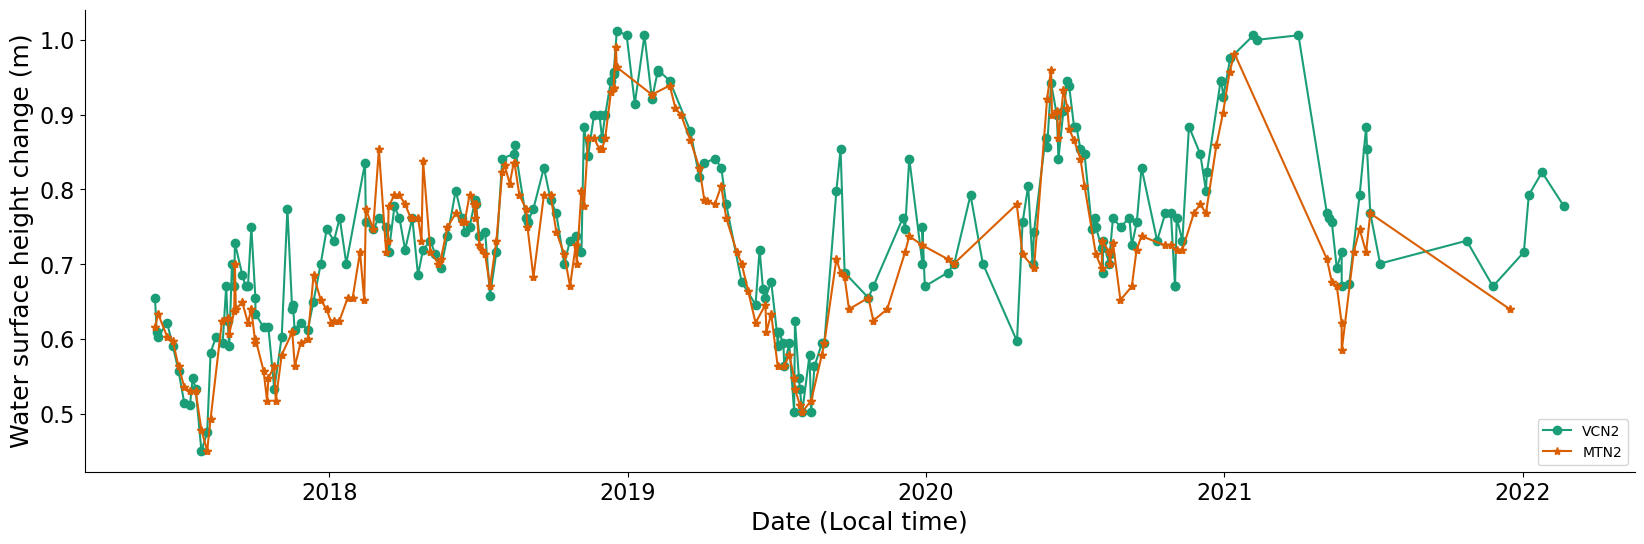

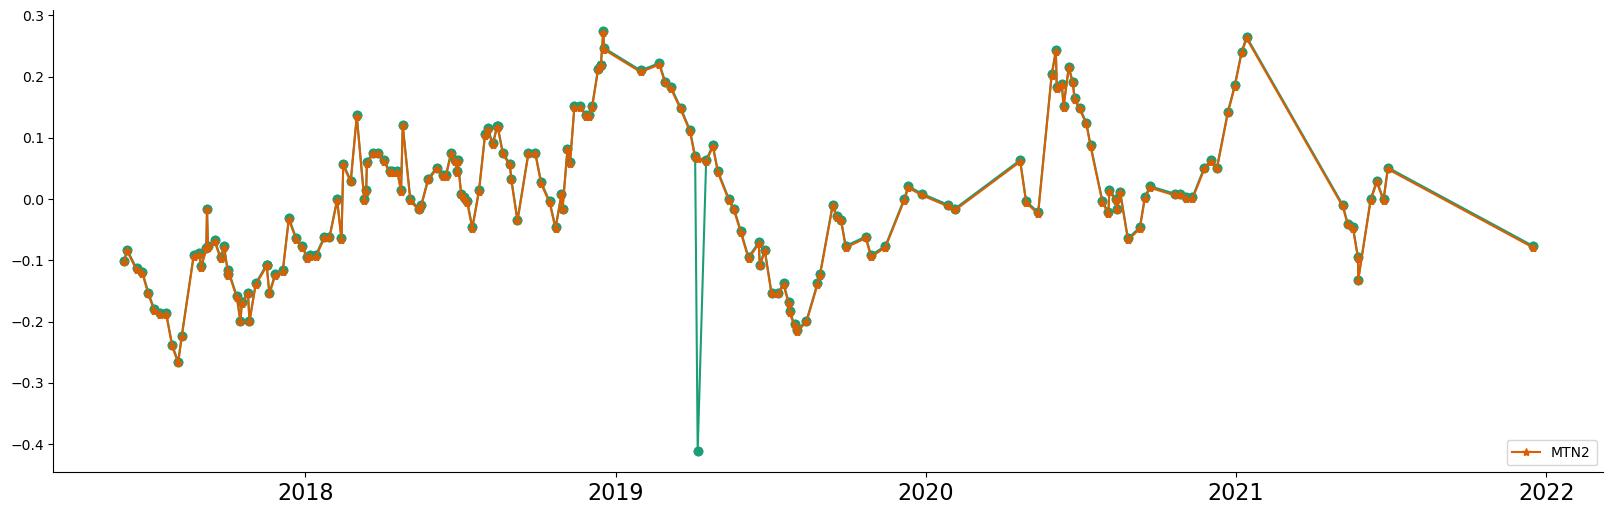

In [19]:
df_MTN2=df_ground_ts.loc[df_ground_ts[st_id_fd]=='MTN2'].copy()
df_VCN2=df_ground_ts.loc[df_ground_ts[st_id_fd]=='VCN2'].copy()


st_id_fd='gauge_id'
st_id='VCN2'
date_fd='decimal_y'
height_fd='height'

fig, ax=plt.subplots(figsize=(20, 6))

df1=df_VCN2
df1=df1.sort_values(by=date_fd)
# plt.plot(df1[date_fd], df1[height_fd]-df1[height_fd].mean(), marker='o', label='VCN2')
plt.plot(df1[date_fd], df1[height_fd], marker='o', label='VCN2', color='#1b9e77')

df2=df_MTN2
df2=df2.sort_values(by=date_fd)
# plt.plot(df2[date_fd], df2[height_fd]-df2[height_fd].mean(), marker='*', label='MTN2')

plt.plot(df2[date_fd], df2[height_fd], marker='*', label='MTN2', color='#d95f02')

ax.set_xlabel('Date (Local time)', fontsize=18)
ax.set_ylabel('Water surface height (m)',fontsize=18)
    
ax.set_yticklabels(ax.get_yticks(),size = 16)
# Make ticks on occurrences of each month:
# ax.xaxis.set_major_locator(mdates.MonthLocator())
# ax.xaxis.set_minor_locator(mdates.MonthLocator())
# Get only the month to show in the x-axis:
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(fontsize=16)
# ax.set_xlim(df1[date_fd].min(), df1[date_fd].max())
# plt.gcf().autofmt_xdate()
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
for pos in ['top', 'right']:
    plt.gca().spines[pos].set_visible(False)

plt.legend(loc='lower right')

plt.figure(figsize=(20, 6))

df1=df_ground_ex
df1=df1.sort_values(by=date_fd)
plt.plot(df1[date_fd], df1[height_fd]-df1[height_fd].mean(), marker='o', color='#1b9e77')
# plt.plot(df1[date_fd], df1[height_fd], marker='o', label='VCN2')
df2=df_MTN2
df2=df2.sort_values(by=date_fd)
plt.plot(df2[date_fd], df2[height_fd]-df2[height_fd].mean(), marker='*', label='MTN2', color='#d95f02')

ax.set_xlabel('Date (Local time)', fontsize=18)
ax.set_ylabel('Water surface height change (m)',fontsize=18)
    
ax.set_yticklabels(ax.get_yticks(),size = 16)
# Make ticks on occurrences of each month:
# ax.xaxis.set_major_locator(mdates.MonthLocator())
# ax.xaxis.set_minor_locator(mdates.MonthLocator())
# Get only the month to show in the x-axis:
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(fontsize=16)
# ax.set_xlim(df1[date_fd].min(), df1[date_fd].max())
# plt.gcf().autofmt_xdate()
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
for pos in ['top', 'right']:
    plt.gca().spines[pos].set_visible(False)


plt.legend(loc='lower right')

print (df1.shape, df2.shape)

(238, 14) (256, 14)
(238, 14) (256, 14)


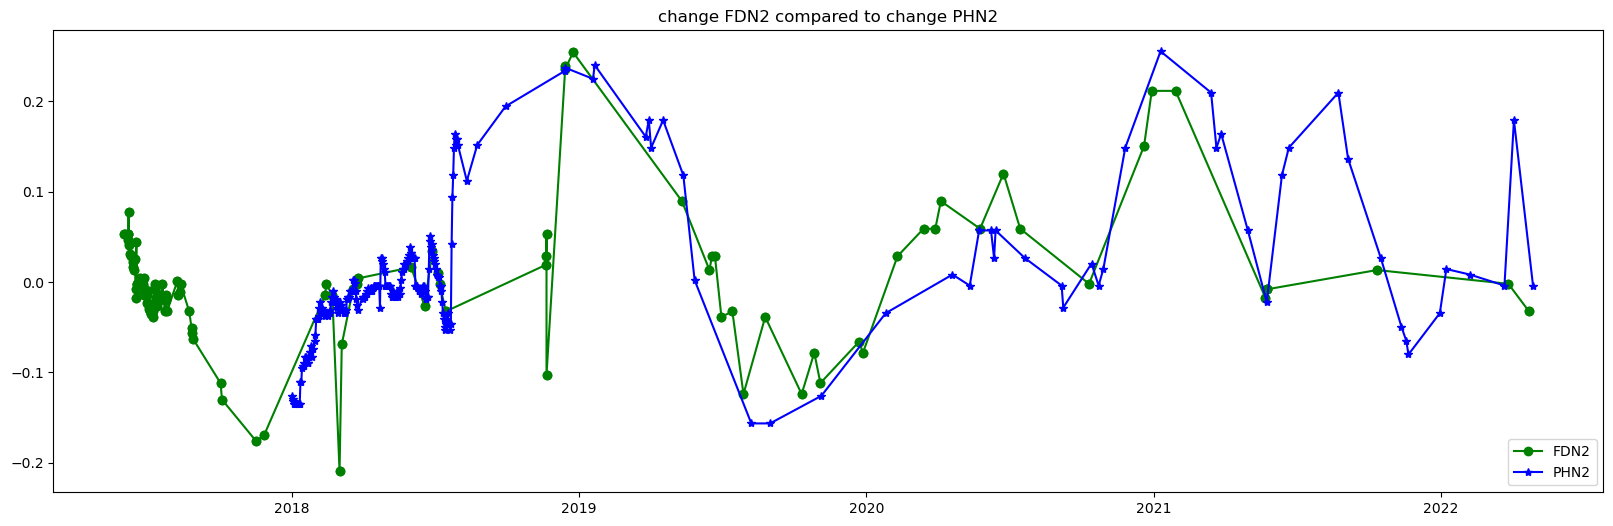

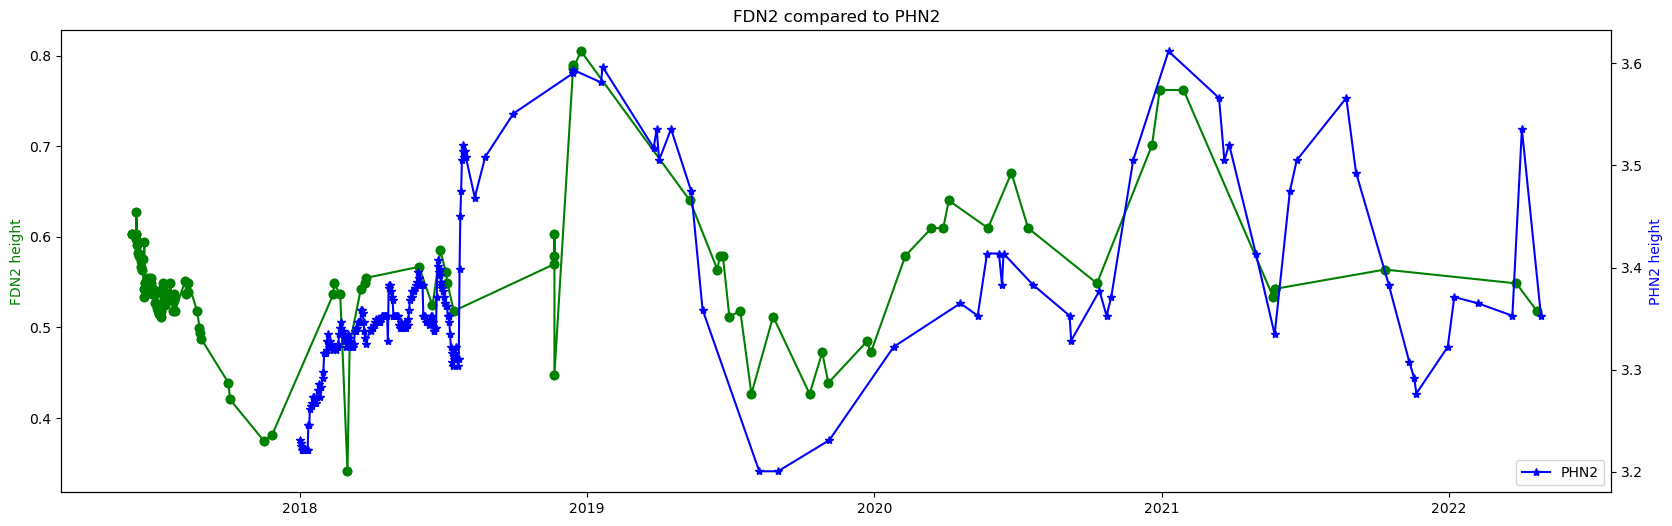

In [20]:
df_PHN2=df_ground_ts.loc[df_ground_ts[st_id_fd]=='PHN2'].copy()

df=df_ground_ts.copy()
st_id_fd='gauge_id'
st_id='FDN2'
date_fd='decimal_y'
height_fd='height'
low_lim=-.4
high_lim=.4

df_ground_ex, df_ground_re,df_diff_to_remove=extract_data_gauge(df, st_id_fd, st_id, date_fd, height_fd, low_lim, high_lim)
df_ground_ex_PH, df_ground_re_PH,df_diff_to_remove_PH=extract_data_gauge(df_PHN2, st_id_fd, 'PHN2', date_fd, height_fd, low_lim, high_lim)

# df_ground_fixed=df_ground_ex.loc[df_ground_ex['date']!='2019-04-07 14:55:00']
# df_ground_ts=df_ground_expd.concat((df_ground_re,df_ground_fixed), axis=0)

#plot goes in here
# df1=df_ground_ex

plt.figure(figsize=(20, 6))

df1=df[df[st_id_fd]==st_id]
df1=df1.sort_values(by=date_fd)
plt.plot(df1[date_fd], df1[height_fd]-df1[height_fd].mean(), 'g-',marker='o', label='FDN2')
df2=df_PHN2
df2=df2.sort_values(by=date_fd)
plt.plot(df2[date_fd], df2[height_fd]-df2[height_fd].mean(),'b-', marker='*', label='PHN2')
plt.title('change '+st_id+' compared to change '+'PHN2')
plt.legend(loc='lower right')
print (df1.shape, df2.shape)

fig, ax=plt.subplots(figsize=(20, 6))

ax2=ax.twinx()
df1=df[df[st_id_fd]==st_id]
df1=df1.sort_values(by=date_fd)
ax.plot(df1[date_fd], df1[height_fd], 'g-', marker='o', label='FDN2')
df2=df_PHN2
df2=df2.sort_values(by=date_fd)
ax2.plot(df2[date_fd], df2[height_fd], 'b-',marker='*', label='PHN2')

ax.set_ylabel('FDN2 height', color='g')
ax2.set_ylabel('PHN2 height', color='b')
plt.title(st_id+' compared to '+'PHN2')
plt.legend(loc='lower right')
print (df1.shape, df2.shape)

In [21]:
df_ground_ex.loc[df_ground_ex['diff']==df_ground_ex[['diff']].max().values[0]]


gauge_id source    decimal_y    height                date  year  \
332707     FDN2  LOCSS  2018.951906  0.789432 2018-12-14 10:41:49  2018   

        month  day  hour  doy    lake_name     lake_id      diff  diff_time  
332707     12   14    10  348  Lake Phelps  7320414542  0.341376   0.065471

### Extract anomalous values stations 12327
#### Reason: There is a extreme value TO-DO: Pending to describe this better

/tmp/ipykernel_1695888/2652770570.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),size = yl_tick_size)
/tmp/ipykernel_1695888/2652770570.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),size = yl_tick_size)


(<Figure size 2000x600 with 1 Axes>, <Figure size 2000x600 with 1 Axes>)

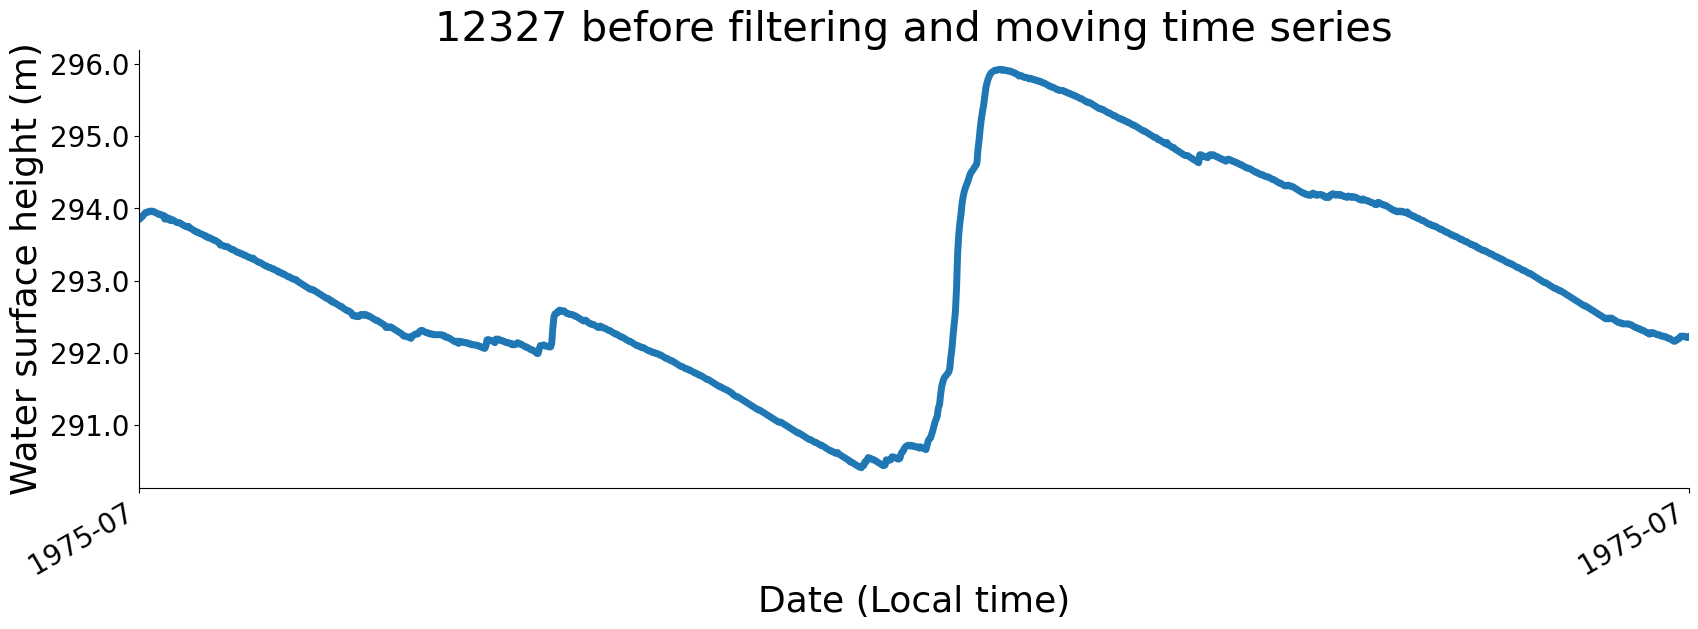

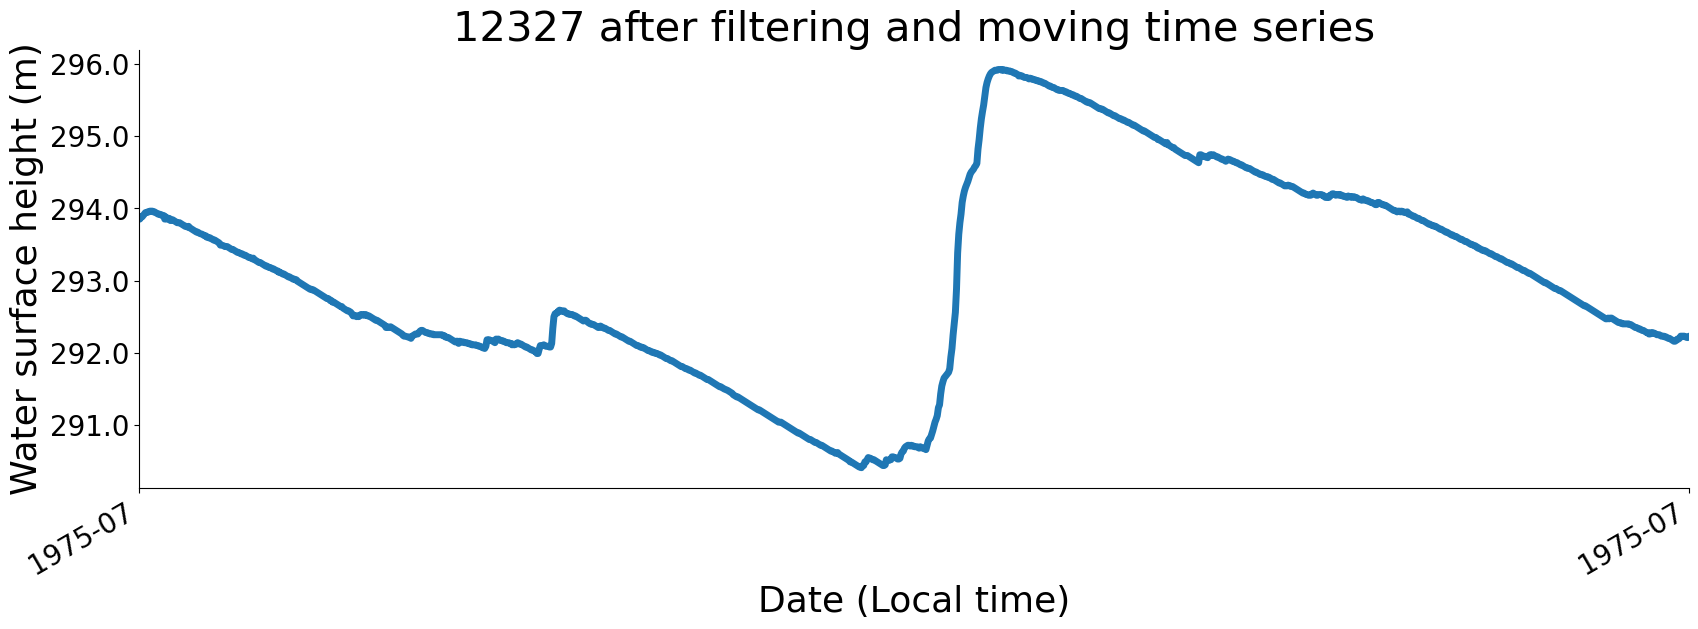

In [29]:
df=df_ground_ts.copy()
st_id='12327'
date_fd='decimal_y'
height_fd='height'
st_id_fd='gauge_id'
low_lim=-5
high_lim=5
df_ground_ex, df_ground_re,df_diff_to_remove=extract_data_gauge(df, st_id_fd, st_id, date_fd, height_fd, low_lim, high_lim)

dates_to_remove=df_diff_to_remove.loc[df_diff_to_remove['diff_time']*365<1, 'date']
df_ground_fixed=df_ground_ex.loc[~df_ground_ex['date'].isin(dates_to_remove)]
df_ground_ts=pd.concat((df_ground_re,df_ground_fixed), axis=0)

#plot goes in here
df1=df_ground_ex

#plot goes in here
title=' filtering and moving time series'
labels={'title':{'label':title, 'size':30},
   'x':{'label':'Date (Local time)', 'font_lbl_s':26, 'tick_s':20,'freq_interval':2},
   'y':{'label':'Water surface height (m)', 'font_lbl_s':26,'tick_s':20 }
   }
plot_ts_preproc(df_ground_ex,df_ground_ts.loc[df_ground_ts[st_id_fd]==st_id], st_id, date_fd, height_fd, labels)


### Subset the time series to a period after 2018-04 station 12327
#### Reason: It seems a problem with the reference value at the begginning of the time series

/tmp/ipykernel_1695888/2652770570.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),size = yl_tick_size)
/tmp/ipykernel_1695888/2652770570.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),size = yl_tick_size)


(<Figure size 2000x600 with 1 Axes>, <Figure size 2000x600 with 1 Axes>)

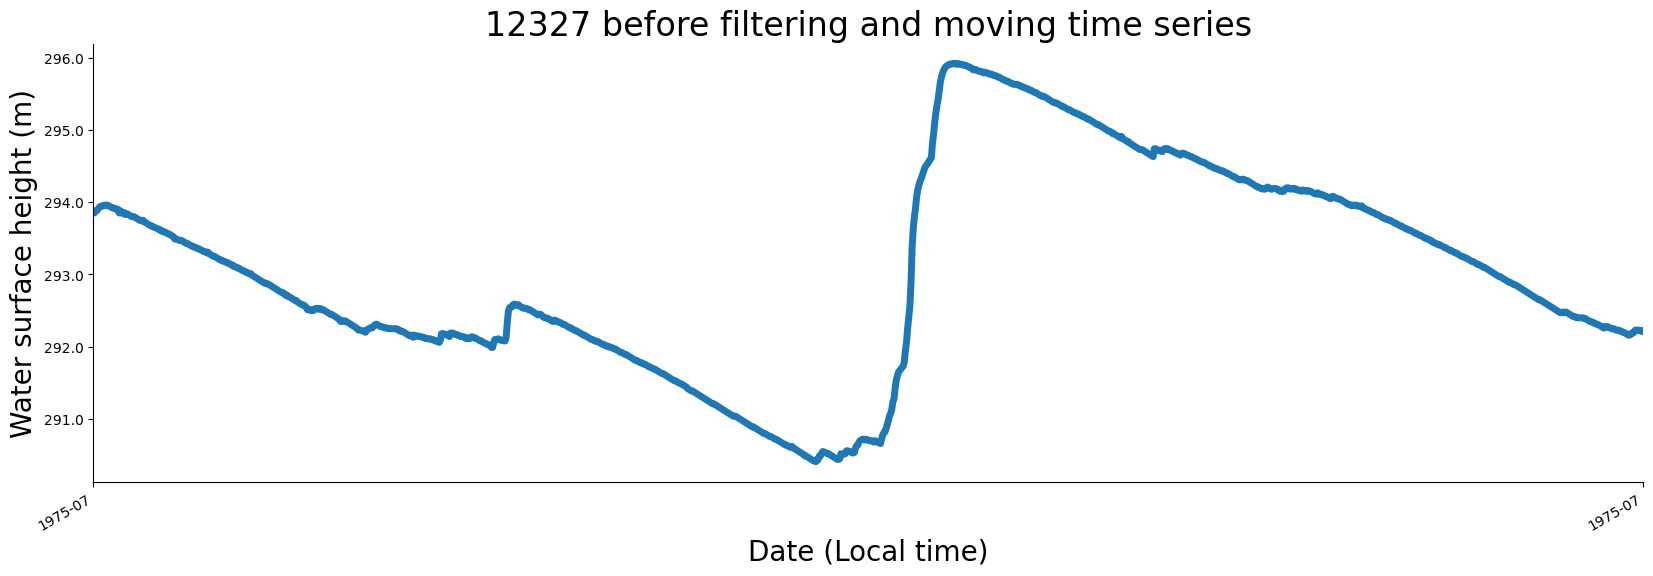

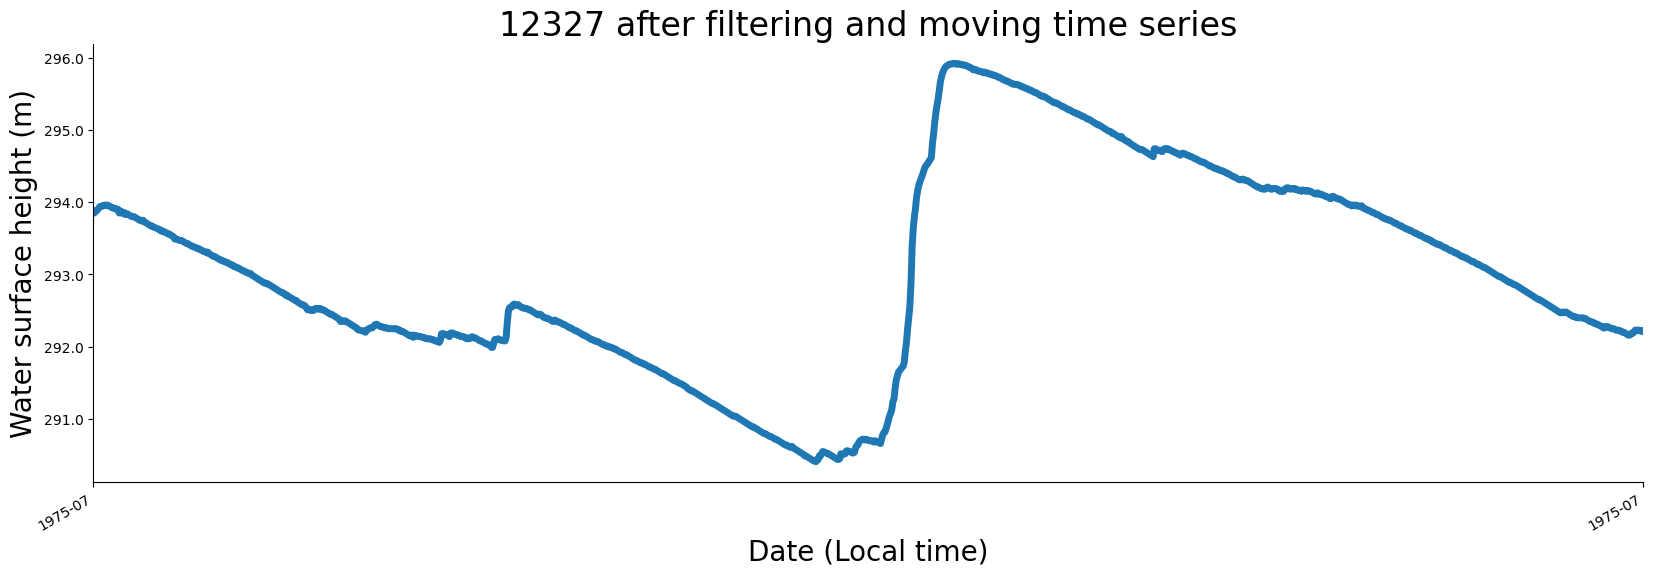

In [30]:
df=df_ground_ts.copy()
st_id='12327'
date_fd='decimal_y'
height_fd='height'
st_id_fd='gauge_id'

df1=df.loc[df['date']>'2018-04-04'] #This is the date when the big Jump occurs. Therefore the plot will be filtered from here 
df1=df1.sort_values(by=date_fd)

df_ground_ts=pd.concat((df_ground_re,df1), axis=0)


#plot goes in here
title=' filtering and moving time series'
labels={'title':{'label':title, 'size':24},
   'x':{'label':'Date (Local time)', 'font_lbl_s':20, 'tick_s':10,'freq_interval':2},
   'y':{'label':'Water surface height (m)', 'font_lbl_s':20,'tick_s':10 }
   }
plot_ts_preproc(df.loc[df[st_id_fd]==st_id],df_ground_ts.loc[df_ground_ts[st_id_fd]==st_id], st_id, date_fd, height_fd, labels)


### Extract anomalous values station 12056
#### Reason: Differences of up to 8 m in a day

/tmp/ipykernel_1695888/2652770570.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),size = yl_tick_size)
/tmp/ipykernel_1695888/2652770570.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(),size = yl_tick_size)


(<Figure size 2000x600 with 1 Axes>, <Figure size 2000x600 with 1 Axes>)

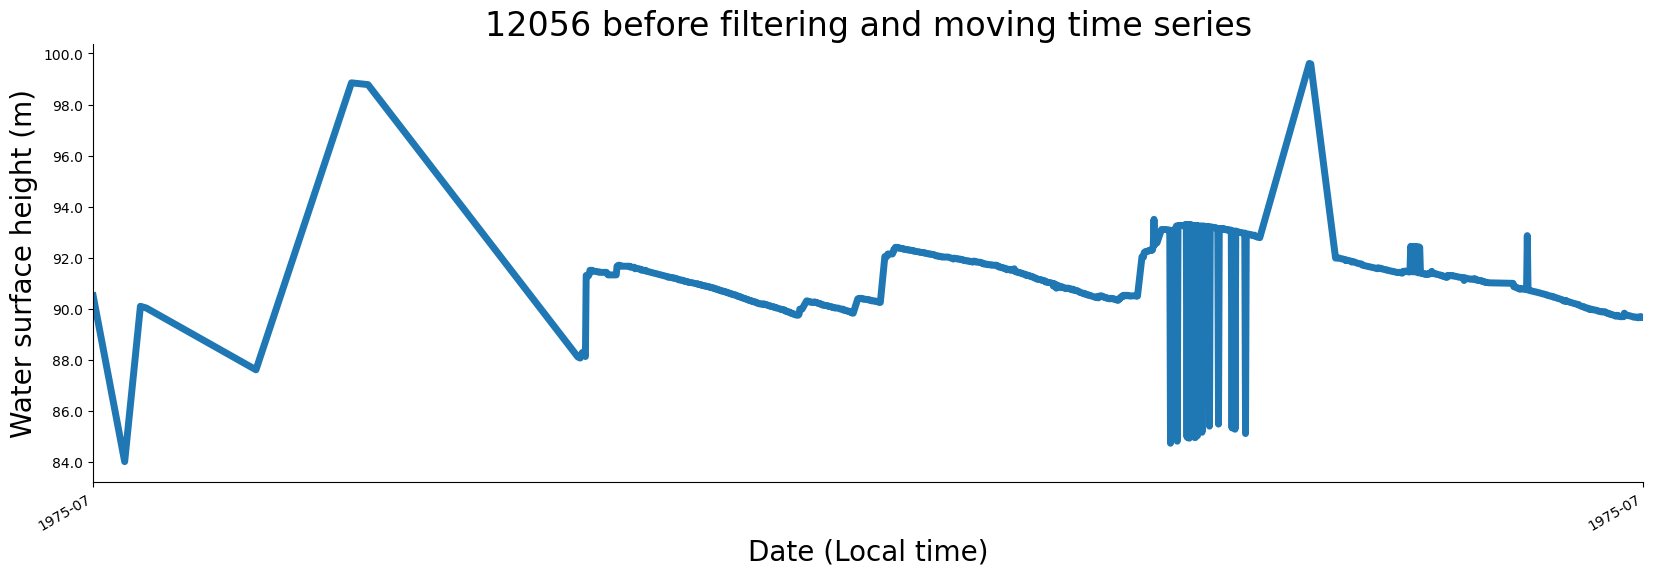

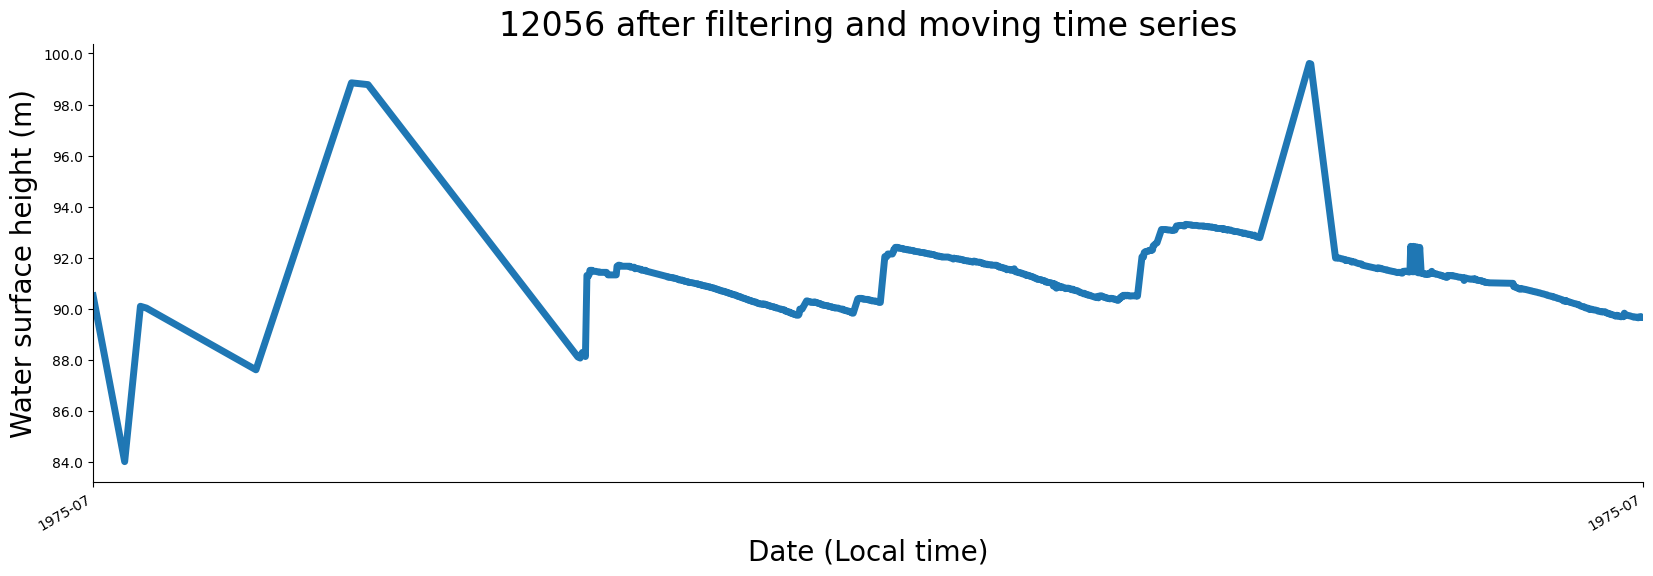

In [40]:
df=df_ground_ts.copy()
st_id='12056'
date_fd='decimal_y'
height_fd='height'
st_id_fd='gauge_id'

low_lim=-1.0
high_lim=1.0
df_ground_ex, df_ground_re,df_diff_to_remove=extract_data_gauge(df, st_id_fd, st_id, date_fd, height_fd, low_lim, high_lim)

#Extract from this gauge those that are with differences more than 8 m in about a day
dates_to_remove=df_diff_to_remove.loc[df_diff_to_remove['diff_time']*365<1, 'date']
df_ground_fixed=df_ground_ex.loc[~df_ground_ex['date'].isin(dates_to_remove)]

#Date to remove 2020-05-07 because it is the only one in the middle of two days in which the change in water elevation was over 8.0 m
df_ground_fixed=df_ground_fixed.loc[df_ground_fixed['date']!='2020-05-07']

# df_ground_ts=pd.concat((df_ground_re,df_ground_fixed), axis=0)

#plot goes in here
title=' filtering and moving time series'
labels={'title':{'label':title, 'size':24},
   'x':{'label':'Date (Local time)', 'font_lbl_s':20, 'tick_s':10,'freq_interval':2},
   'y':{'label':'Water surface height (m)', 'font_lbl_s':20,'tick_s':10 }
       }    
# plot_ts_preproc(df.loc[df[st_id_fd]==st_id],df_ground_ts.loc[df_ground_ts[st_id_fd]==st_id], st_id, date_fd, height_fd, labels)
plot_ts_preproc(df.loc[df[st_id_fd]==st_id],df_ground_fixed.loc[df_ground_fixed[st_id_fd]==st_id], st_id, date_fd, height_fd, labels)


In [41]:
df_ground_fixed.loc[df_ground_fixed['diff'].abs()>.7]

gauge_id source    decimal_y  height       date  year  month  day  \
361909    12056   RVBR  2016.471311   84.00 2016-06-21  2016      6   21   
361910    12056   RVBR  2016.528689   90.09 2016-07-12  2016      7   12   
361912    12056   RVBR  2016.949454   87.60 2016-12-13  2016     12   13   
361913    12056   RVBR  2017.297260   98.85 2017-04-19  2017      4   19   
361915    12056   RVBR  2018.121918   88.10 2018-02-14  2018      2   14   
362260    12056   RVBR  2019.239726   92.04 2019-03-29  2019      3   29   
362573    12056   RVBR  2020.176230   92.03 2020-03-05  2020      3    5   
362723    12056   RVBR  2020.785519   99.61 2020-10-14  2020     10   14   
362725    12056   RVBR  2020.881148   91.98 2020-11-18  2020     11   18   
362808    12056   RVBR  2021.154795   92.44 2021-02-26  2021      2   26   
362809    12056   RVBR  2021.157534   91.45 2021-02-27  2021      2   27   
362812    12056   RVBR  2021.165753   92.44 2021-03-02  2021      3    2   

        hour  doy         lake_name lake_id   diff  diff_time  
361909    12  173  AÃ§ude Boa Vista   12056  -6.50   0.114754  
361910    12  194  AÃ§ude Boa Vista   12056   6.09   0.057377  
361912    12  348  AÃ§ude Boa Vista   12056  -2.42   0.398907  
361913    12  109  AÃ§ude Boa Vista   12056  11.25   0.347807  
361915    12   45  AÃ§ude Boa Vista   12056 -10.68   0.764384  
362260    12   88  AÃ§ude Boa Vista   12056   1.80   0.016438  
362573    12   65  AÃ§ude Boa Vista   12056   1.54   0.016393  
362723    12  288  AÃ§ude Boa Vista   12056   6.83   0.180328  
362725    12  323  AÃ§ude Boa Vista   12056  -7.61   0.090164  
362808    12   57  AÃ§ude Boa Vista   12056   0.99   0.002740  
362809    12   58  AÃ§ude Boa Vista   12056  -0.99   0.002740  
362812    12   61  AÃ§ude Boa Vista   12056   1.00   0.002740

# 4. Save dataframe will all the time series preprocessed 

In [17]:
time_file=datetime.now().strftime("%Y%m%d_%H_%M")
# df_ground_ts.to_csv('../data/results/data_preprocessed.csv', sep=',')
#Backup
df_ground_ts.to_csv('../data/results/data_preprocessed_'+time_file+'.csv', sep=',')

In [18]:
time_file

'20230503_12_13'

In [42]:
#Only if data has been generated
df_ground_ts=pd.read_csv('../data/results/data_preprocessed_20230503_12_13.csv', sep=',', low_memory=False, parse_dates=['date'])

#Read all the gauges with time series to process. This file contain the lake ids that will be used in the computated. It is used to filter the shapefile dataframe
path= '../data/alti_timeseries/lonlat_vs_altis_ed.csv'


if platform.system()=='Linux':
    altis_csv=pd.read_csv(path, sep=',',encoding='iso-8859-1')
else:
    altis_csv=pd.read_csv(path, sep=',', encoding='windows-1252')  

#Get all lakes 
if platform.system()=='Linux':
    path_lakes='/home/angelica/Dropbox/Research/LOCSS/other_lakes/Selected_lakes/all_lakes_paper.shp'#wgs84_f.shp'
else:
    path_lakes='C:/Users/amgomez/Dropbox/Research/LOCSS/other_lakes/Selected_lakes/all_lakes_paper.shp'#wgs84_f.shp'

df_sel_lakes=gpd.read_file(path_lakes)

df_ground_ts.info()
# import icecream as ic


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452807 entries, 0 to 452806
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Unnamed: 0  452807 non-null  int64         
 1   gauge_id    452807 non-null  object        
 2   source      452807 non-null  object        
 3   decimal_y   452807 non-null  float64       
 4   height      452199 non-null  float64       
 5   date        452807 non-null  datetime64[ns]
 6   year        452807 non-null  int64         
 7   month       452807 non-null  int64         
 8   day         452807 non-null  int64         
 9   hour        452807 non-null  int64         
 10  doy         452807 non-null  int64         
 11  lake_name   202095 non-null  object        
 12  lake_id     202095 non-null  float64       
 13  diff        5937 non-null    float64       
 14  diff_time   5937 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(6), object(

In [43]:
import gc

gc.collect()

1805

In [45]:
gauges=df_ground_ts['gauge_id'].unique()
df_ground_ts_temp=pd.DataFrame()
print(df_ground_ts.shape, 'Size with duplicates')
for st in gauges:
    df=df_ground_ts.loc[(df_ground_ts['gauge_id']==st)].copy()#df_ground_ts[df_ground_ts.duplicated(['height','date'])])]
    No=df[df.duplicated()].shape[0]
    print('Gauge '+st,[No, df.shape[0]])
    df=df.drop_duplicates(keep='first')
    df_ground_ts_temp=pd.concat((df_ground_ts_temp, df), axis=0)
    del df
print(df_ground_ts_temp.shape, 'Size without duplicates')


(452807, 15) Size with duplicates
Gauge 2464800 [1366, 8426]
Gauge 6903880 [1367, 9088]
Gauge 6604000 [1324, 9216]
Gauge 1824 [1399, 9436]
Gauge 2830 [28096, 75798]
Gauge 1830 [15181, 118124]
Gauge 2832 [1752, 6465]
Gauge 2028 [1186, 32187]
Gauge 2231 [1246, 27042]
Gauge 2234 [1246, 27830]
Gauge 2300 [1246, 21521]
Gauge 2316 [23518, 62503]
Gauge BLB2 [48, 96]
Gauge BTN2 [366, 902]
Gauge CFN2 [25, 67]
Gauge FDN2 [86, 324]
Gauge HMT2 [53, 106]
Gauge MAB2 [483, 966]
Gauge MCW2 [12, 24]
Gauge MRP2 [4, 8]
Gauge PAW2 [16, 32]
Gauge PHN2 [170, 428]
Gauge QUL2 [145, 290]
Gauge RLH2 [54, 108]
Gauge SAW2 [408, 816]
Gauge SLL2 [88, 176]
Gauge SPA2 [70, 140]
Gauge VCN2 [158, 368]
Gauge WEW2 [224, 448]
Gauge YSL2 [192, 384]
Gauge 19069 [1462, 9593]
Gauge 19060 [1463, 9595]
Gauge 19126 [1464, 9597]
Gauge 12030 [1365, 3584]
Gauge 12036 [240, 1176]
Gauge KHB2 [410, 820]
Gauge TAB2 [439, 878]
Gauge MTN2 [266, 636]
Gauge 12327 [0, 1353]
Gauge 12056 [1, 2256]
(364168, 15) Size without duplicates


In [16]:
df_ground_ts_temp.columns

Index(['Unnamed: 0', 'gauge_id', 'source', 'decimal_y', 'height', 'date',
       'year', 'month', 'day', 'hour', 'doy', 'lake_name', 'lake_id', 'diff',
       'diff_time'],
      dtype='object')

In [46]:
import gc
df_ground_ts=df_ground_ts_temp.copy()
# del df_ground_ts_temp
gc.collect()

0

In [18]:
df_ground_ts.columns

Index(['Unnamed: 0', 'gauge_id', 'source', 'decimal_y', 'height', 'date',
       'year', 'month', 'day', 'hour', 'doy', 'lake_name', 'lake_id', 'diff',
       'diff_time'],
      dtype='object')

# 5. Preprocess altis data of the selected lakes 

In [47]:



#Read each file and convert it to dataframe
g_path='../data/alti_timeseries/'

time_fig=datetime.now().strftime("%Y%m%d_%H_%M")

df_final_altis=pd.DataFrame()
df_final_ground=pd.DataFrame()
    

tf=TimezoneFinder()

#Filter to lakes approved
#---------------------------
# approve_locss=df_sel_lakes.loc[df_sel_lakes['AprovedFor']==1]['gauge_id'].values #['HMT2','PHN2','SAW2','BTN2','QUL2', 'WEW2', 'CFN2','YSL2','SLL2','TAB2','KHB2']

#HURRY Parch code so it works with the new gauges at the two lakes that have two gauges
# Fix, modify the shapefile so it can get the coordinates of the two gauges


# altis_csv=altis_csv.loc[altis_csv['station_id'].isin(approve_locss)]

lon_fd='lon'
lat_fd='lat'

df_gts=df_ground_ts.copy()

st_fd='gauge_id'
st_date_fd='date'
altis_date_fd = 'date'  # Same value for Sentinel-3A/B
altis_height_fd = 'ice1_ku_SurfHeight_alti_median'  # Same value for Sentinel-3A/B
n_obs_altis='number of sample' #Number of observations
nodataalti=-9999

wse_ref='e'
i=1

#################CHANGE WITH N COMPARISON ####################
#----ALL
this_source='ALL'

#----ARHN
# this_source='ARHN'

##---LOCSS
# this_source='LOCSS'

#---USGS
# this_source='USGS'

##----RVBR
# this_source='RVBR'

#-----ICECV

# this_source='ICECV'
###########################################################

if this_source not in ['ALL', 'ICECV']:
    altis_csv=altis_csv.loc[altis_csv['source']==this_source].copy()

data_source=this_source

altis_csv['tz']=altis_csv.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)
#filter only altis time series with ground observations
altis_w_gts_csv=altis_csv.loc[altis_csv['lake_id'].notna()]

altis_w_gts_csv=altis_w_gts_csv.sort_values(by='source')

for index,row in altis_w_gts_csv.iterrows():
    # print(row['station_id'])
    altis_name=row['altivs_nam']
    st_id=row['station_id']
    ncolgeoid=row['ncolgeoid']
    lake_id=str(int(row['lake_id']))
    orbit_nu=int(row['orbit'])
    # Call every altis relative to the ellipsoide
    
    # is_Sentinel=altis_name.find('Sentinel-3')
    # if is_Sentinel!=-1:
    if ncolgeoid!='No':
        #Call the function with geoid field and wse_type='e'
        df_altis, df_ground_st=open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd,n_obs_altis,
                                                        nodataalti,ncolgeoid=ncolgeoid,wse_ref=wse_ref)
    else:
        #Call the function with geoid field and wse_type='g'
        df_altis, df_ground_st=open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd,n_obs_altis, nodataalti)
    
    print('Station '+row['tz']+' ncolgeoid: '+str(ncolgeoid).upper(), 'Gauge ID: '+st_id+' ground_st: '+str(not df_ground_st.empty)+' df_altis: '+str(df_altis.shape)+' Lake ID: '+lake_id)
    
    # print(df_altis.columns)
    if not df_ground_st.empty:
        # print('df_altis\n', df_altis.head(3))
        # print('df_ground_st '+st_id+'\n', df_ground_st.head(3))
        df_altis['ground_st_1']=st_id
        lake_name=df_ground_st['lake_name'].iloc[0]
        #Convert time in df_gts_st to UTC
        source=df_ground_st['source'].iloc[0]
        
        df_ground_st['date_utc']=[timezone(row['tz']).localize(date).astimezone(utc.zone) for date in df_ground_st[st_date_fd]]
        
        #print('\nBefore: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        df_ground_st['altis_d_1']=altis_name
        df_ground_st['orbit']=orbit_nu
        #Get the dates of altis
        # ic(df_altis[altis_date_fd].dt.normalize().max())
        (df_altis_c, df_ground_c)=get_common_period(df_ts1=df_altis, df_ts2=df_ground_st, 
                                                    date_ts1_fd=altis_date_fd, date_ts2_fd='date_utc', delta_days=True, ndays=10)

#         
        
        if source=='USGS':
            df_ground_c=get_date_time_cols(df_ground_c, 'date_utc', has_hour=False)
        else:
            df_ground_c=get_date_time_cols(df_ground_c, 'date_utc', has_hour=True)
        #print('\nAfter: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        df_ground_c=df_ground_c.sort_values(by=['decimal_y'])
        df_altis_c=df_altis_c.sort_values(by=['decimal_y'])
        # print(df_altis_c.head())
        delta=5
        for delta in range (1,11):
            median_fd='median_d_'+str(delta)
            mean_fd='mean_d_'+str(delta)
            std_fd='std_d_'+str(delta)
            mad_fd='mad_d_'+str(delta) #Median absolute deviation
            count_fd='count_d_'+str(delta)
            criteria_fd='type_m_d_'+str(delta)
        

            # Get moving windows
            df_altis_c[[median_fd,mad_fd, mean_fd, std_fd,count_fd, criteria_fd]]=df_altis_c.apply(lambda x: moving_window_around_date(df_ground_c,
                                                                                                              x[altis_date_fd],
                                                                                                              delta,
                                                                                                              'height',
            # Interpolate in moving windows                                                                                                  'date_utc'), axis=1).apply(pd.Series)
            median_fd='val_w_int_d_'+str(delta)
            mean_fd='mean_w_int_d_'+str(delta)
            std_fd='std_w_int_d_'+str(delta)
            mad_fd='mad_w_int_d_'+str(delta) #Median absolute deviation
            count_fd='count_w_int_d_'+str(delta)
            criteria_fd='type_w_int_d_'+str(delta)
        

            # Get interpolate in moving windows
            df_altis_c[[median_fd,mad_fd, mean_fd, std_fd,count_fd, criteria_fd]]=df_altis_c.apply(lambda x: moving_window_around_date(df_ground_c,
                                                                                                              x[altis_date_fd],
                                                                                                              delta,
                                                                                                              'height',
                                                                                                              'date_utc',
                                                                                                               'linear'), axis=1).apply(pd.Series)
            
            #second approach, the closest date
            #delta=5
            val_cd_fd='val_cd_d_'+str(delta)
            criteria_fd='type_cd_d_'+str(delta)
            closer_dt_fd='ndays_cd_d_'+str(delta)
            mea_cd_fd='mea_cd_d_'+str(delta)
            std_cd_fd='std_cd_d_'+str(delta)
            mad_cd_fd='mad_cd_d_'+str(delta) #Median absolute deviation
            n_cd_fd='n_cd_d_'+str(delta)
            n_days_cd_fd='n_days_cd_d_'+str(delta)
            # Get closer value around a date if more than one median
            df_altis_c[[val_cd_fd,criteria_fd,closer_dt_fd,mea_cd_fd, mad_cd_fd, std_cd_fd,n_cd_fd,n_days_cd_fd]]=df_altis_c.apply(lambda x: closer_value_around_date(df_ground_c,
                                                                                                              x[altis_date_fd],
                                                                                                              delta,
                                                                                                              'height',
                                                                                                              'date_utc'), axis=1).apply(pd.Series)
            
            val_cd_fd='val_int_d_'+str(delta)
            criteria_fd='type_int_d_'+str(delta)
            closer_dt_fd='ndays_int_d_'+str(delta)
            mea_cd_fd='mea_int_d_'+str(delta)
            std_cd_fd='std_int_d_'+str(delta)
            mad_cd_fd='mad_int_d_'+str(delta) #Median absolute deviation
            n_cd_fd='n_int_d_'+str(delta)
            n_days_cd_fd='n_days_int_d_'+str(delta)
            # Get closer value around a date if more than one, linearly interpolate
            df_altis_c[[val_cd_fd,criteria_fd,closer_dt_fd,mea_cd_fd, mad_cd_fd, std_cd_fd,n_cd_fd,n_days_cd_fd]]=df_altis_c.apply(lambda x: closer_value_around_date(df_ground_c,
                                                                                                              x[altis_date_fd],
                                                                                                              delta,
                                                                                                              'height',
                                                                                                              'date_utc', 
                                                                                                              'linear'), axis=1).apply(pd.Series)
        #Get interpolated data 
        datast1_2_ts2dy, corr_ts1ts2, ns_ts2, rmsd_ts2, ampl_ts1=interp_ts12ts2_stat(df_ground_c['decimal_y'].to_numpy(), df_ground_c['height'].to_numpy(), 
                                        df_altis_c['decimal_y'].to_numpy(), df_altis_c['height'].to_numpy())
        
        df_altis_c['int_height']=pd.Series(datast1_2_ts2dy)
        df_altis_c['int_corr_ts1ts2']=corr_ts1ts2
        df_altis_c['int_rmsd_ts2']=rmsd_ts2
        #add columns
        df_altis_c['lake_name']=lake_name
        df_altis_c['source']=df_ground_c['source'].iloc[0]
        df_altis_c['lake_id']=lake_id
        df_altis_c['orbit']=orbit_nu
        df_final_altis=pd.concat((df_final_altis,df_altis_c), axis=0)
        df_final_ground=pd.concat((df_final_ground,df_ground_c), axis=0)
        
    

df_final_ground=df_final_ground.rename(columns={'altis_d_1':'name_altis'}, errors='raise')
df_final_altis=df_final_altis.rename(columns={'ground_st_1':'gauge_id'}, errors='raise')



Station America/Argentina/Salta ncolgeoid: GEOID_01_MEDIAN Gauge ID: 1824 ground_st: True df_altis: (73, 9) Lake ID: 6610142963
Station America/Argentina/Salta ncolgeoid: GEOID_EIGEN6C4D_MEDIAN Gauge ID: 2028 ground_st: True df_altis: (104, 9) Lake ID: 6620000613
Station America/Argentina/Salta ncolgeoid: GEOID_MEDIAN Gauge ID: 2028 ground_st: True df_altis: (157, 9) Lake ID: 6620000613
Station America/Argentina/Salta ncolgeoid: GEOID_01_MEDIAN Gauge ID: 2028 ground_st: True df_altis: (77, 9) Lake ID: 6620000613
Station America/Argentina/Catamarca ncolgeoid: GEOID_01_MEDIAN Gauge ID: 2234 ground_st: True df_altis: (76, 9) Lake ID: 6610149612
Station America/Argentina/Catamarca ncolgeoid: GEOID_01_MEDIAN Gauge ID: 2234 ground_st: True df_altis: (75, 9) Lake ID: 6610149612
Station America/Argentina/Catamarca ncolgeoid: GEOID_01_MEDIAN Gauge ID: 2316 ground_st: True df_altis: (41, 9) Lake ID: 6530064712
Station America/Edmonton ncolgeoid: GEOID_01_MEDIAN Gauge ID: HMT2 ground_st: True df_

In [77]:
help(closer_value_around_date)

Help on function closer_value_around_date in module ts_preprocesing:

closer_value_around_date(df, date, delta, v_fd, d_fd, method='median')
    Moving window of a value around a date (targeting date) +- n days defined by delta
    Inputs:
        df: Dataframe containing the dates and values
        date: date around the one the closer value will be estimated
        v_fd: name of the value column in df
        d_fd: name of the date column in df
        method: method implemented when more than one value is closer to the date. Default median. Options: 'linear' for linear interpolation
                scipy.interpolate.griddata is used to do the linear interpolation
    Output:
        val_cd: value obtained from the analysis 
        type_cd: 'closed', if only one date was the closest, 'median': if more than two dates where equally closed
        ndays_cd: amount of days between the targe date and the closest date
        n_cd: number of data used to calculate value
        mea_cd: m

In [24]:
(np.datetime64('2009-01-01 10:00') - np.datetime64('2009-01-01 12:00'))/np.timedelta64(1,'D')

-0.08333333333333333

In [8]:
df_final_altis.columns

Index(['decimal_y', 'height', 'nobs_altis', 'year', 'month', 'day', 'hour',
       'date', 'name_altis', 'gauge_id',
       ...
       'std_int_d_10', 'n_int_d_10', 'n_days_int_d_10', 'int_height',
       'int_corr_ts1ts2', 'int_rmsd_ts2', 'lake_name', 'source', 'lake_id',
       'orbit'],
      dtype='object', length=237)

In [33]:
gc.collect()

19883

In [48]:
#Parching FDN2 and VCN2
df_final_altis.loc[df_final_altis['gauge_id']=='FDN2', 'lake_name']= 'Lake Phelps West' #df_final_altis.loc[df_final_altis['gauge_id']=='PHN2', 'lake_name'].iloc[0]
df_final_altis.loc[df_final_altis['gauge_id']=='PHN2', 'lake_name']= df_final_altis.loc[df_final_altis['gauge_id']=='FDN2', 'lake_name'].iloc[0][:-4]+ ' East'
# df_final_altis.loc[df_final_altis['gauge_id']=='PHN2', 'lake_name']
df_final_altis.loc[df_final_altis['gauge_id']=='VCN2', 'lake_name']= df_final_altis.loc[df_final_altis['gauge_id']=='MTN2', 'lake_name'].iloc[0][:-4]+'East'
df_final_altis.loc[df_final_altis['gauge_id']=='MAB2', 'lake_name']='Matian Haor' #Althought this lake is not included given deliation
# df_final_altis.loc[df_final_altis['gauge_id']=='VCN2', 'lake_name']

In [49]:
df_final_altis.loc[df_final_altis['lake_name'].isna(), 'gauge_id'].unique()#=='MTN2', 'lake_name'].iloc[0]

array([], dtype=object)

### Mark only the lakes that will be in the paper

In [53]:
#Add a mark to only places that have been selected for evaluation
gauges_to_process=df_sel_lakes.loc[df_sel_lakes.ol_Aproved==1, 'gauge_id']
f=[gauges_to_process.copy(),pd.Series(['VCN2', 'FDN2'], name='gauge_id')]

approve_paper =pd.concat(f, axis=0)

df_final_altis['for_paper']=None
df_final_ground['for_paper']=None
df_final_altis.loc[df_final_altis['gauge_id'].isin(approve_paper), 'for_paper']='Y'
df_final_ground.loc[df_final_ground['gauge_id'].isin(approve_paper),'for_paper']='Y'

In [54]:
approve_paper 

0       19060
1       19069
2       19126
3       12030
4       12036
5       12056
6       12327
7        BLB2
8        1824
9        2028
10       2234
11       2316
12    2464800
13       BTN2
14       CFN2
15       HMT2
16       KHB2
17       PHN2
18       QUL2
20       SAW2
21       SLL2
22       TAB2
23       WEW2
24       YSL2
30       MTN2
71    6903880
72    6604000
0        VCN2
1        FDN2
Name: gauge_id, dtype: object

In [55]:
df_final_altis.to_csv('../data/results/matchups_several_methods.csv')

/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice

/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice

/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice

/home/angelica/.conda/envs/geo_env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice



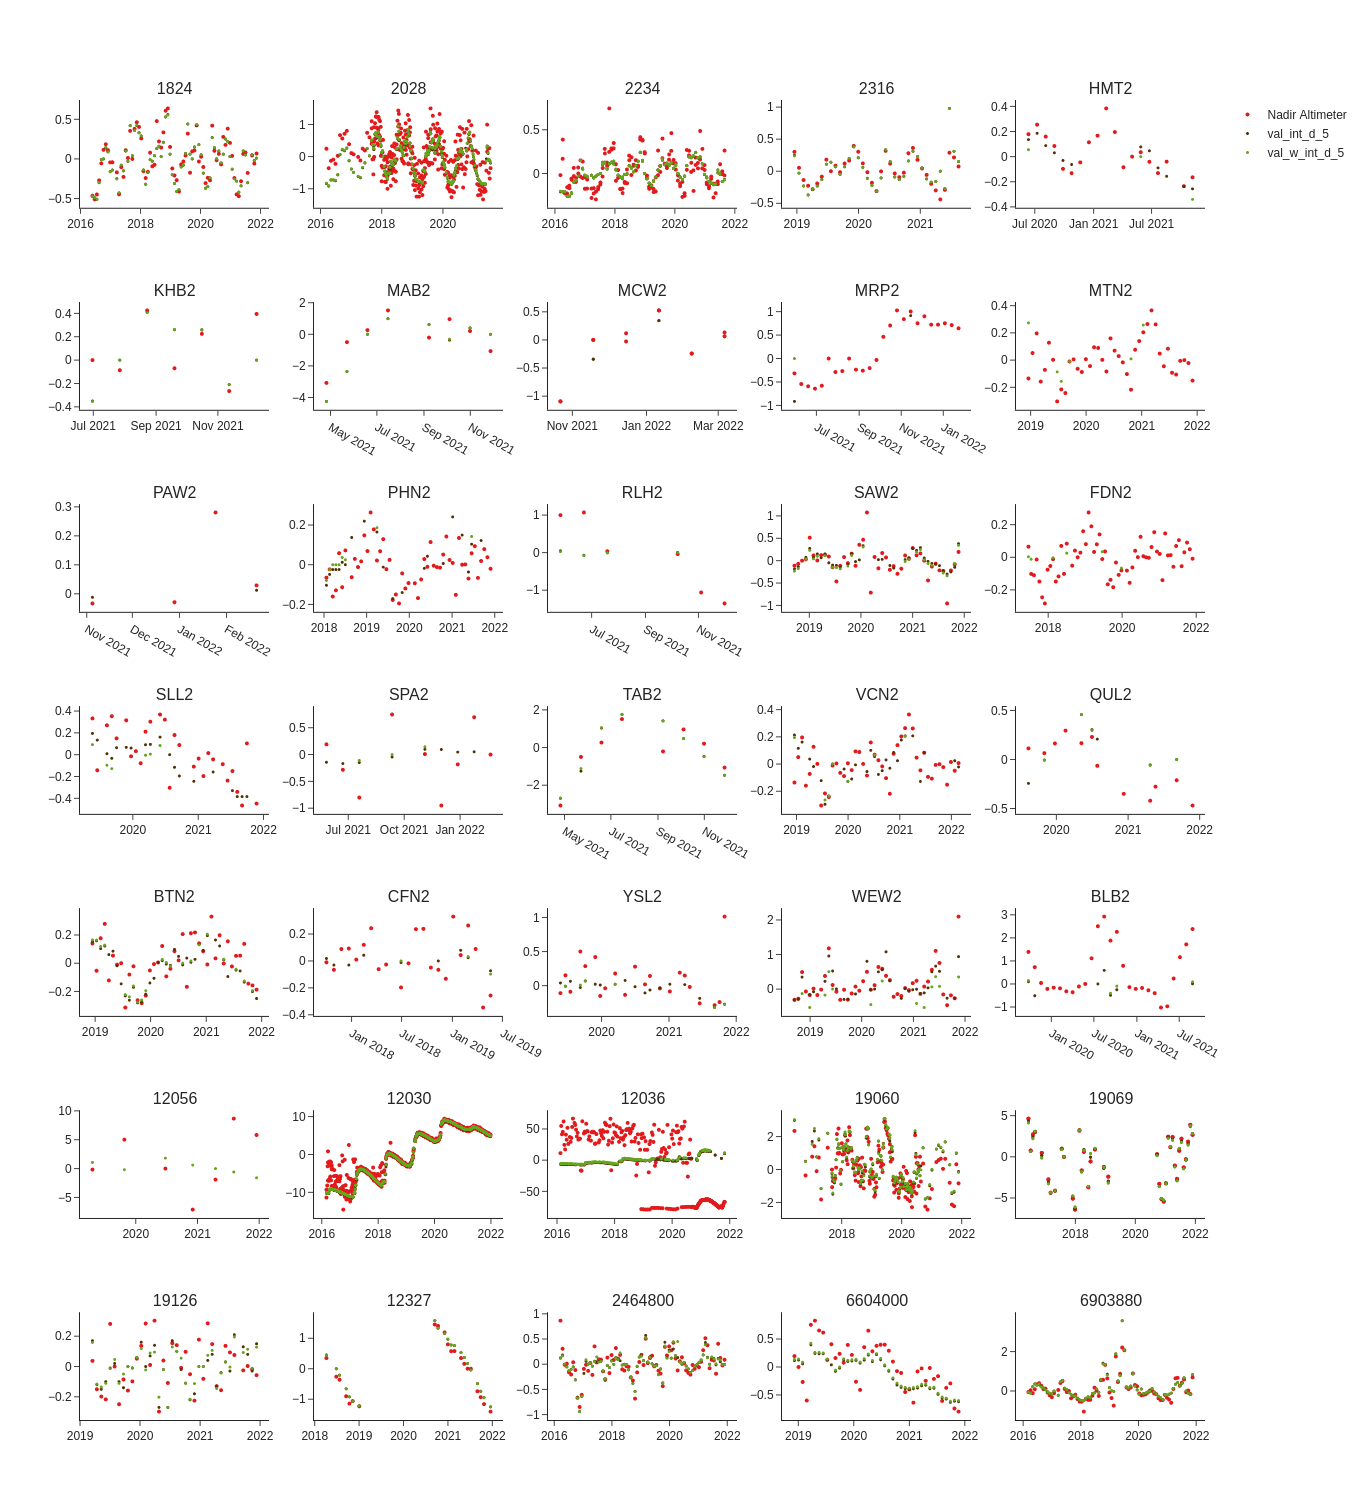

In [57]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
rw=7
cl=5


gauges=df_final_altis.gauge_id.unique()
gauges

# columns_show=['val_cd_d_4', 'median_d_4','val_cd_d_5', 'median_d_5', 'int_height','val_cd_d_3', 'median_d_3']
# columns_show=['val_int_d_1', 'val_int_d_2', 'val_int_d_3', 'val_int_d_4', 
#               # 'val_cd_d_5', 
#               # 'int_height',
#               'val_int_d_5', 
#               'val_int_d_6',
#               'val_int_d_8',
#               'val_int_d_9',
#               'val_int_d_10'               
#              ]#,
              # 'val_int_d_5']
columns_show=['val_int_d_5', 'val_w_int_d_5']
              # 'val_int_d_5']

# colors_dict=['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d']
# colors_dict=['#543005','#8c510a','#bf812d','#dfc27d','#f6e8c3','#c7eae5','#80cdc1','#35978f','#01665e','#003c30']
colors_dict=['#543005','#66a61e']

    
fig=make_subplots(rows=rw, cols=cl, subplot_titles=gauges)

c=1
r=1
show_l=True
for gid in gauges:
    df_p=df_final_altis.loc[df_final_altis['gauge_id']==gid]
    df_p=df_p.sort_values('date')
    df_org=df_final_ground.loc[(df_ground_ts['gauge_id']==gid)].sort_values('date')
    df_plot=df_org[['date','height']].dropna(subset=['height'])
    # fig.add_trace(go.Scatter(x=df_plot['date'], y=df_plot['height']-df_plot['height'].median(), name='Ground obs',
    #                          marker=dict(size=4,color='#666666'),
    #                          mode="markers", showlegend=show_l), row=r, col=c)
    
    df_plot_na=df_p[['date','height']].dropna(subset=['height'])
    fig.add_trace(go.Scatter(x=df_plot_na['date'], y=df_plot_na['height']-df_plot_na['height'].median(skipna=True), name='Nadir Altimeter',
                             marker=dict(size=4,color='#e31a1c'),
                             mode="markers", showlegend=show_l), row=r, col=c)
    for col in columns_show:
        df_plot=df_p[['date',col, 'height']].dropna(subset=[col, 'height'], how='any')
        # df_plot_ob=pd.merge(df_plot_na, df_plot, how='inner', on='date').dropna()
        # if df_plot_ob[col].count()>0:
        if c==1 and r==1:
            
            fig.add_trace(go.Scatter(x=df_plot['date'],y=df_plot[col]-df_plot[col].median(skipna=True), name=col,
                                    marker=dict(size=3,color=colors_dict[columns_show.index(col)]),
                                    mode="markers"), row=r,col=c)
            show_l=False
        else:
            
            fig.add_trace(go.Scatter(x=df_plot['date'],y=df_plot[col]-df_plot[col].median(skipna=True), name=col,
                                    marker=dict(size=3, color=colors_dict[columns_show.index(col)]),
                                    mode="markers", 
                                    showlegend=False), row=r,col=c)
    if c==cl:
        
        c=1
        r=r+1
        
    else:
        c=c+1
    
# df_p=df_melt.loc[df_melt['gauge_id']==gauges[0]]
# fig.add_trace(go.Scatter(x=df_p['date'],y=df_p['int_height'], row=1,col=1))
fig.update_layout(width=1300, height=1500, template='simple_white')                                                
fig.show()

110

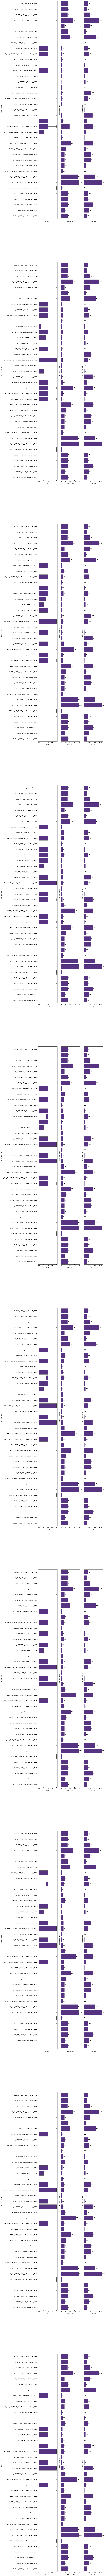

In [59]:
#Plot the results on getting the time series that match with satellite median
import seaborn as sns

fig, axes = plt.subplots(10, 3, figsize=(10, 400), sharey=True)
names_field='name_altis'
df=df_final_altis.loc[df_final_altis['for_paper']=='Y'].copy()
df['orbit_lake_source']=[x.split('-')[1] for x in df[names_field]]
df['orbit_lake_source']=df['orbit_lake_source']+'__'+df['lake_name']+'__'+df['source']
df.sort_values(by=['source'], inplace=True, ascending=True)


names_field='orbit_lake_source'
y_order=df[names_field].unique()

flierprops = dict(marker='x', markerfacecolor='None', markersize=2,  markeredgecolor='gray')
for i in range(1,11):
    val_days=str(i)
    row_axes=i-1
    
    
    # data_field='std_d_'+val_days
    
    #Median among values within the window
    # g=sns.boxplot(data=df, y=names_field, x=data_field, ax=axes[0,0],linewidth=0.5, flierprops=flierprops, order=y_order)
    # axes[0,0].set_xlim(-0.5, 2)

    # g.set_xticklabels(g.get_xticklabels(),rotation=90)
    # data_field='std_cd_d_'+val_days
    # g= sns.boxplot(data=df, y=names_field, x=data_field, ax=axes[1,0],linewidth=0.5, flierprops=flierprops, order=y_order)
    # axes[1,0].set_xlim(-0.01, .3)
    # g.set_xticklabels(g.get_xticklabels(), rotation=90)

    # Closest value within the window
    # data_field='mad_d_'+val_days
    # g=sns.boxplot(data=df, y=names_field, x=data_field, ax=axes[0,1],linewidth=0.5, flierprops=flierprops, order=y_order)
    # axes[0,0].set_xlim(-0.5, 2)
    # g.set_xticklabels(g.get_xticklabels(),rotation=90)
    # data_field='mad_cd_d_'+val_days
    # g= sns.boxplot(data=df, y=names_field, x=data_field, ax=axes[1,1],linewidth=0.5, flierprops=flierprops, order=y_order)
    # axes[1,0].set_xlim(-0.01, .3)
    # g.set_xticklabels(g.get_xticklabels(), rotation=90)

    # data_field='count_d_'+val_days
    # g=sns.boxplot(data=df, y=names_field, x=data_field, ax=axes[0,0],linewidth=0.5, flierprops=flierprops, order=y_order, color='#54278f')
    # # axes[0].set_xlim(-0.5, 2)
    # # g.set_xticklabels(g.get_xticklabels(),rotation=90)
    
    
    
    data_field='n_cd_d_'+val_days
    g= sns.boxplot(data=df, y=names_field, x=data_field, ax=axes[row_axes,0],linewidth=0.5, flierprops=flierprops, order=y_order, color='#54278f')
    # axes[1].set_xlim(-0.01, .3)

#     df['match']=df[['height', 'median_d_'+val_days]].count(axis=1)
#     df.loc[df['match']==1, 'match']=np.nan
#     df.loc[df['match']==2, 'match']=1
#     df_count_obs=df[[names_field, 'match']].groupby(names_field).count().reset_index()

#     g=sns.barplot(data=df_count_obs,x='match',y=names_field, ax=axes[0,1], order=y_order, color='#54278f')
#     for i in g.containers:
#         g.bar_label(i,)

    df['match_cd_'+val_days]=df[['height', 'val_cd_d_'+val_days]].count(axis=1)
    df.loc[df['match_cd_'+val_days]==1, 'match_cd_'+val_days]=np.nan
    df.loc[df['match_cd_'+val_days]==2, 'match_cd_'+val_days]=1
    df_count_obs_cd=df[[names_field, 'match_cd_'+val_days]].groupby(names_field).count().reset_index()
    
    # sns.set_color_codes("muted")
    g=sns.barplot(data=df_count_obs_cd,y=names_field,x='match_cd_'+val_days, ax=axes[row_axes,1], order=y_order, color='#54278f')    
    for i in g.containers:
        g.bar_label(i,)


    field='nobs_altis'
    df_count_obs=df[[names_field, field]].groupby(names_field).sum().reset_index()

    g=sns.barplot(data=df_count_obs,y=names_field,x=field, ax=axes[row_axes,2], order=y_order, color='#54278f')    
    # g=sns.barplot(data=df_count_obs,x=field,y=names_field, ax=axes[0,2], order=y_order, color='#54278f')    
    for i in g.containers:
         g.bar_label(i,)

    
     #std  standard deviation
    #mad median absolute deviation
df_count_matches=df.copy()
gc.collect()

In [77]:
days_matches=['n_cd_d_'+str(x) for x in range(1,11)]
print(df_count_matches[days_matches])

    n_cd_d_1  n_cd_d_2  n_cd_d_3  n_cd_d_4  n_cd_d_5  n_cd_d_6  n_cd_d_7  \
0        1.0       1.0       1.0       1.0       1.0       1.0       1.0   
1        1.0       1.0       1.0       1.0       1.0       1.0       1.0   
0        1.0       1.0       1.0       1.0       1.0       1.0       1.0   
71       1.0       1.0       1.0       1.0       1.0       1.0       1.0   
70       1.0       1.0       1.0       1.0       1.0       1.0       1.0   
..       ...       ...       ...       ...       ...       ...       ...   
67       1.0       1.0       1.0       1.0       1.0       1.0       1.0   
68       1.0       1.0       1.0       1.0       1.0       1.0       1.0   
69       1.0       1.0       1.0       1.0       1.0       1.0       1.0   
71       1.0       1.0       1.0       1.0       1.0       1.0       1.0   
76       1.0       1.0       1.0       1.0       1.0       1.0       1.0   

    n_cd_d_8  n_cd_d_9  n_cd_d_10  
0        1.0       1.0        1.0  
1        1.0   

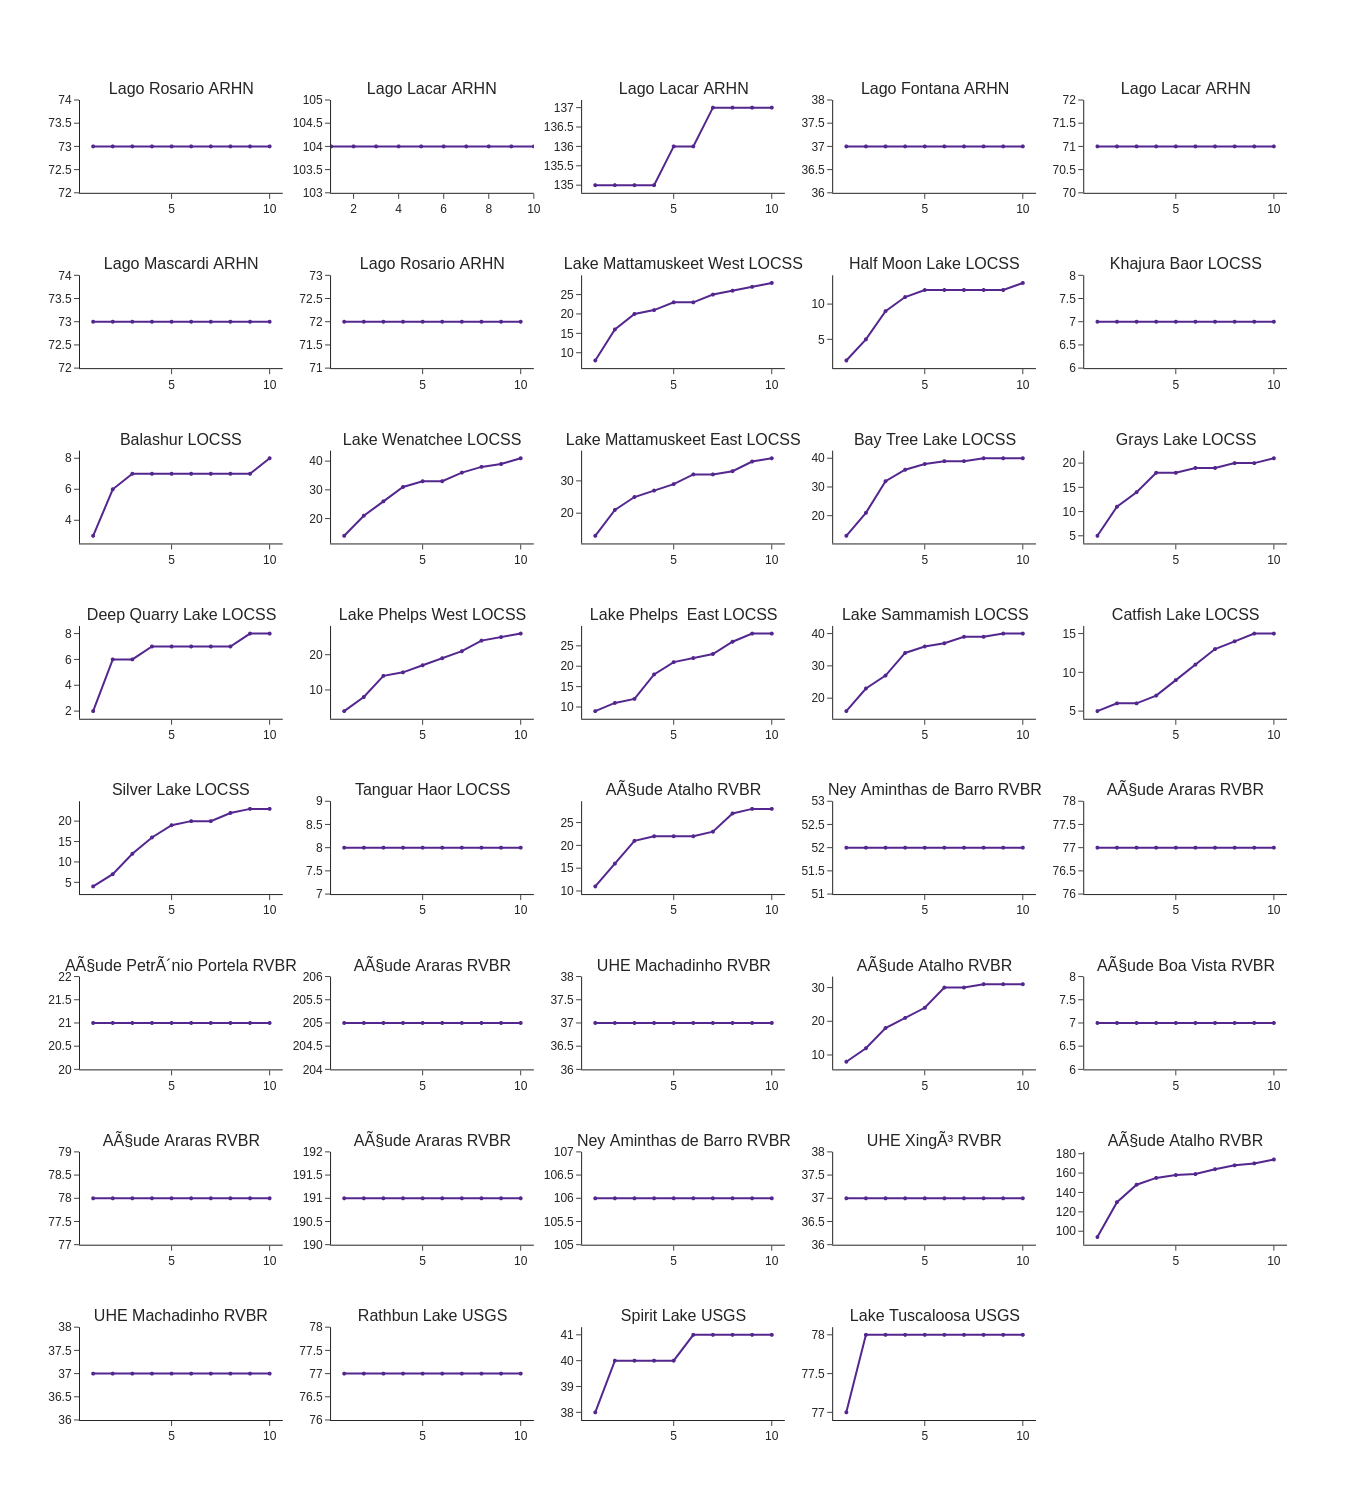

In [85]:
# fig, axes = plt.subplots(10, 3, figsize=(10, 400), sharey=True)
# df=df_final_altis.loc[df_final_altis['for_paper']=='Y'].copy()
# df['orbit_lake_source']=[x.split('-')[1] for x in df[names_field]]
# df['orbit_lake_source']=df['orbit_lake_source']+'__'+df['lake_name']+'__'+df['source']
# df.sort_values(by=['source'], inplace=True, ascending=True)
import plotly.graph_objects as go
from plotly.subplots import make_subplots
rw=8
cl=5

name_matches=['match_cd_'+str(x) for x in range(1,11)]
days_matches=['n_cd_d_'+str(x) for x in range(1,11)]
name_field='orbit_lake_source'
df=df_count_matches[[name_field]+name_matches+days_matches].copy()
df
val_days=str(1)




df_count_obs_cd_final=pd.DataFrame()
for match_oa in name_matches:
    df_plot=df.melt(id_vars=[name_field])
    df_count_obs_cd=df_plot.loc[df_plot['variable']==match_oa].groupby([name_field,'variable']).count().reset_index()
    df_count_obs_cd['n_days']=int(match_oa.split('_')[2])
    df_count_obs_cd_final=pd.concat((df_count_obs_cd_final, df_count_obs_cd), axis=0)
    
    # fig.add_trace(x=df_count_obs_cd[]
c=r=1



df_count_obs_cd_final['source']=[x.split('_')[len(x.split('_'))-1] for x in df_count_obs_cd_final[name_field]]
df_count_obs_cd_final=df_count_obs_cd_final.sort_values('source')
matches=df_count_obs_cd_final[name_field].unique()
matchess=[x.split('_')[len(x.split('_'))-3]+'\n'+x.split('_')[len(x.split('_'))-1] for x in matches]

fig= make_subplots(rows=rw, cols=cl, subplot_titles=matchess)
for nm in matches:
    df_plot=df_count_obs_cd_final.loc[df_count_obs_cd_final[name_field]==nm]
    df_plot=df_plot.sort_values('n_days')
    fig.add_trace(go.Scatter(x=df_plot['n_days'], y=df_plot['value'],
                            marker=dict(size=4,color='#54278f'), showlegend=False), row=r, col=c)
    if c==cl:
        
        c=1
        r=r+1
        
    else:
        c=c+1
    
fig.update_layout(width=1300, height=1500, template='simple_white',xaxis2=dict(range=[1,10]))                                                
fig.show()


In [81]:
df_plot.variable.unique()

array(['match_cd_1', 'match_cd_2', 'match_cd_3', 'match_cd_4',
       'match_cd_5', 'match_cd_6', 'match_cd_7', 'match_cd_8',
       'match_cd_9', 'match_cd_10', 'n_cd_d_1', 'n_cd_d_2', 'n_cd_d_3',
       'n_cd_d_4', 'n_cd_d_5', 'n_cd_d_6', 'n_cd_d_7', 'n_cd_d_8',
       'n_cd_d_9', 'n_cd_d_10'], dtype=object)

In [81]:
df_count_matches



decimal_y      height  nobs_altis  year  month  day  hour  \
0   2016.397797  826.443375         5.0  2016      5   25    14   
1   2016.257204  683.591096         5.0  2016      4    4     3   
0   2016.183436  683.404394         4.0  2016      3    8     3   
71  2021.515439  663.096265         5.0  2021      7    8     3   
70  2021.441467  663.828686         8.0  2021      6   11     3   
..          ...         ...         ...   ...    ...  ...   ...   
67  2021.166235   38.729032         2.0  2021      3    2    16   
68  2021.240207   38.967267         4.0  2021      3   29    16   
69  2021.314180   38.828589         3.0  2021      4   25    16   
71  2021.462125   38.539228         3.0  2021      6   18    16   
76  2021.874395  243.699009         8.0  2021     11   16     3   

                        date                               name_altis  \
0  2016-05-25 14:00:00+00:00  AlTiS_TimeSeries_Sentinel-3A_0562_S4128   
1  2016-04-04 03:00:00+00:00  AlTiS_TimeSeries_Sentinel-3A_0635_S4324   
0  2016-03-08 03:00:00+00:00  AlTiS_TimeSeries_Sentinel-3A_0635_S4324   
71 2021-07-08 03:00:00+00:00  AlTiS_TimeSeries_Sentinel-3A_0749_S4016   
70 2021-06-11 03:00:00+00:00  AlTiS_TimeSeries_Sentinel-3A_0749_S4016   
..                       ...                                      ...   
67 2021-03-02 16:00:00+00:00  AlTiS_TimeSeries_Sentinel-3A_0194_N3338   
68 2021-03-29 16:00:00+00:00  AlTiS_TimeSeries_Sentinel-3A_0194_N3338   
69 2021-04-25 16:00:00+00:00  AlTiS_TimeSeries_Sentinel-3A_0194_N3338   
71 2021-06-18 16:00:00+00:00  AlTiS_TimeSeries_Sentinel-3A_0194_N3338   
76 2021-11-16 03:00:00+00:00  AlTiS_TimeSeries_Sentinel-3A_0635_N4086   

   gauge_id  ...  match_cd_1  match_cd_2  match_cd_3  match_cd_4  match_cd_5  \
0      1824  ...         1.0         1.0         1.0         1.0         1.0   
1      2234  ...         1.0         1.0         1.0         1.0         1.0   
0      2234  ...         1.0         1.0         1.0         1.0         1.0   
71     2028  ...         1.0         1.0         1.0         1.0         1.0   
70     2028  ...         1.0         1.0         1.0         1.0         1.0   
..      ...  ...         ...         ...         ...         ...         ...   
67  2464800  ...         1.0         1.0         1.0         1.0         1.0   
68  2464800  ...         1.0         1.0         1.0         1.0         1.0   
69  2464800  ...         1.0         1.0         1.0         1.0         1.0   
71  2464800  ...         1.0         1.0         1.0         1.0         1.0   
76  6903880  ...         1.0         1.0         1.0         1.0         1.0   

   match_cd_6  match_cd_7 match_cd_8  match_cd_9  match_cd_10  
0         1.0         1.0        1.0         1.0          1.0  
1         1.0         1.0        1.0         1.0          1.0  
0         1.0         1.0        1.0         1.0          1.0  
71        1.0         1.0        1.0         1.0          1.0  
70        1.0         1.0        1.0         1.0          1.0  
..        ...         ...        ...         ...          ...  
67        1.0         1.0        1.0         1.0          1.0  
68        1.0         1.0        1.0         1.0          1.0  
69        1.0         1.0        1.0         1.0          1.0  
71        1.0         1.0        1.0         1.0          1.0  
76        1.0         1.0        1.0         1.0          1.0  

[2355 rows x 249 columns]

# 6. Generate the matching time series of ground and altimeter observations

In [64]:
time_fig=datetime.now().strftime("%Y%m%d_%H_%M")
df_final_ground.to_csv('../data/results/preprossed_ground_data_'+time_fig+'.csv', sep=',')
df_final_altis.to_csv('../data/results/preprossed_altis_data_'+time_fig+'.csv', sep=',')

In [65]:
time_fig

'20230912_10_39'